In [1]:
#Read in the necessary libraries
import pandas as pd
import numpy as np
import itertools

#Matplotlib section
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

#SKlearn and Scipy Models
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Import for the creation and visualization of decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import make_scorer

#Import for random forest modeling
from sklearn.ensemble import RandomForestClassifier

In [2]:
import xgboost as xgb

#This code prevents the kernel from stopping when XGBoost is running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [3]:
#I import pickle to save certain models
import pickle

In [4]:
#A function that takes in a model and a string with the model name and saves it to the repository
def make_pickle(model, model_name):
    model_pickle_path = 'Classification_Models_After_'+ model_name + '.pkl'
    # Create a variable to pickle and open it in write mode
    model_pickle = open(model_pickle_path, 'wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

In [5]:
#Read in the csv file containing the datafreame
election_df = pd.read_csv('congressional_data_and_targets.csv')

## 1. Create the Boolean Target Variable

The data cleansing process was completed in the notebook titled "Census_Data_API_Work.ipynb"

In [6]:
#Creates a boolean column based on whether the district voted more for the Republican party or not (i.e. Democratic party/ Independent candidate)
election_df['Target_Presidential_R_bool'] = (election_df['Target_Presidential_R'] > election_df['Target_Presidential_D']).astype(int)


In [7]:
election_df.shape

(860, 54)

In [8]:
#Reorganize the dataframe so the target variable is on the right side and the identification cells are on the left
election_df = election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 2. EDA

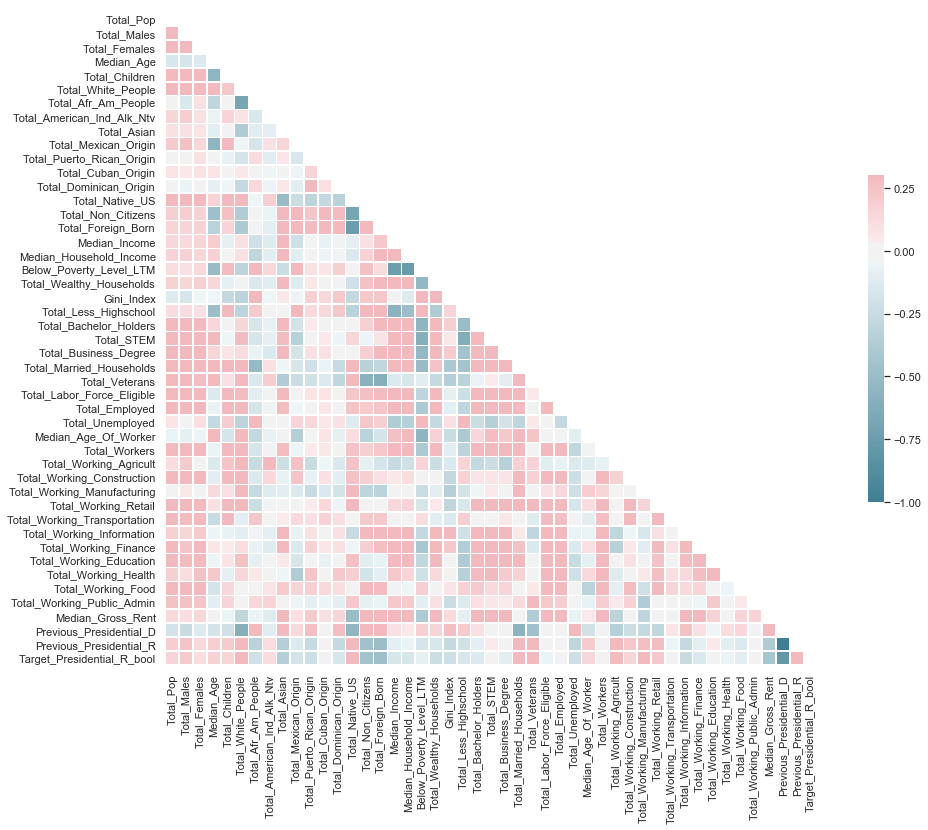

In [9]:
#This cell creates a correlation matrix to view the correlation between continuous features
#and the target variable
sns.set(style="white")

# Compute the correlation matrix
corr = election_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

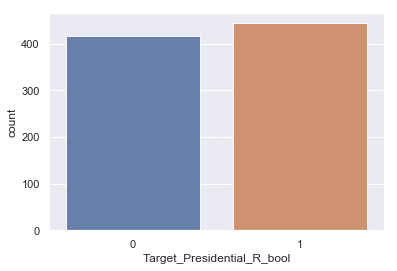

In [10]:
#A histogram of the target variable
sns.set_style('darkgrid')
sns.countplot(election_df['Target_Presidential_R_bool'], alpha=0.9)
#There is a negligible imbalance

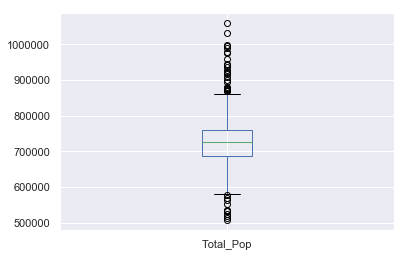

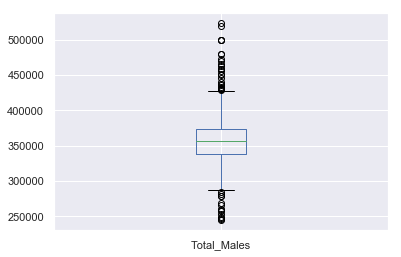

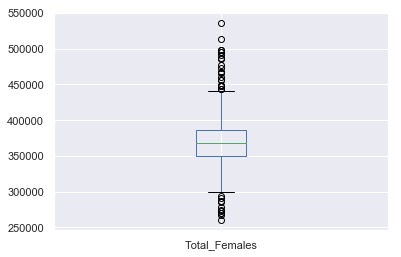

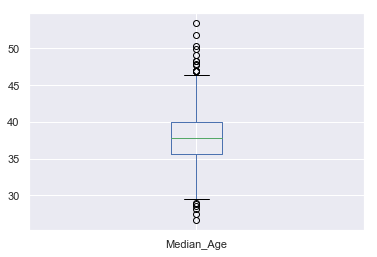

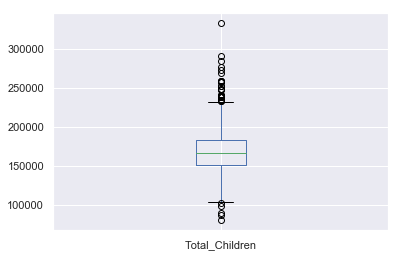

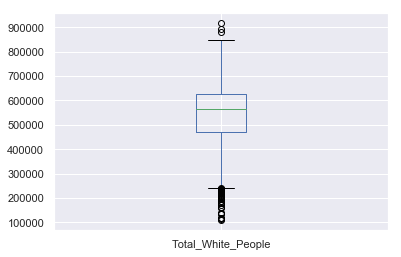

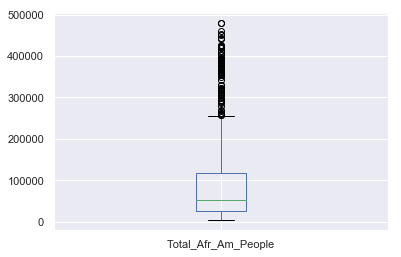

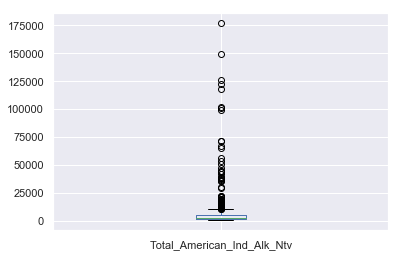

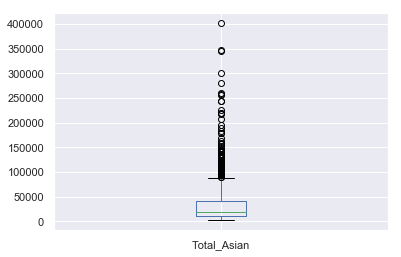

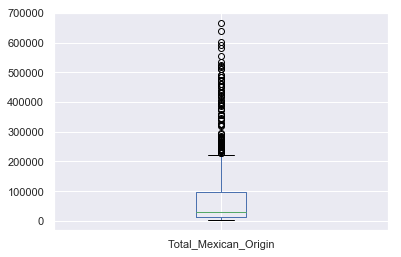

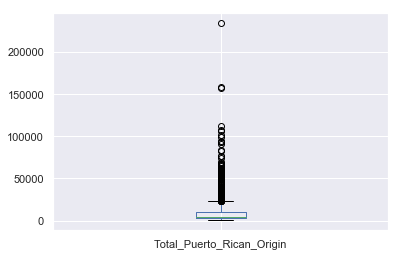

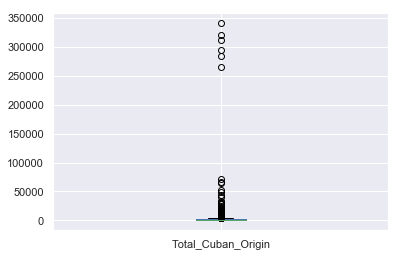

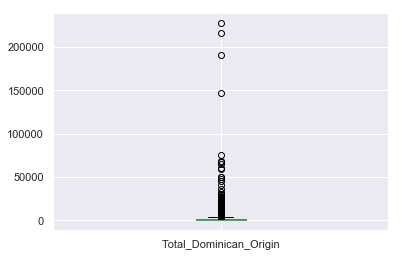

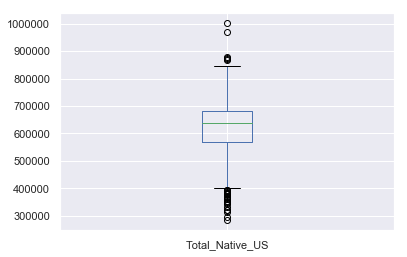

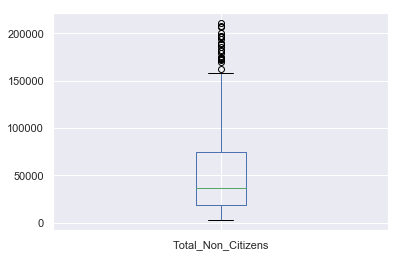

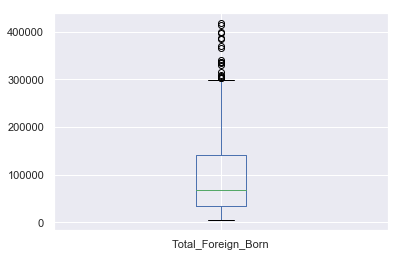

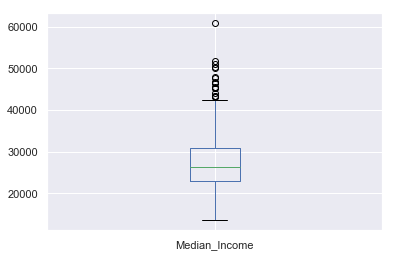

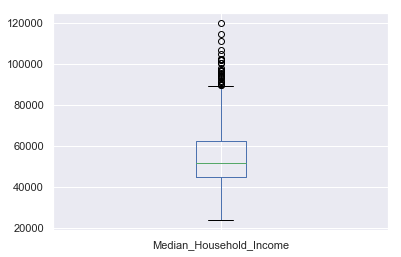

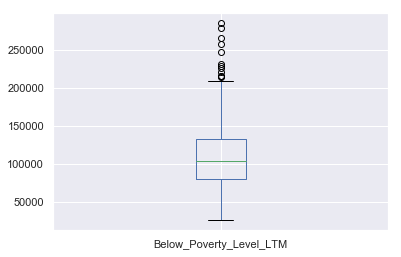

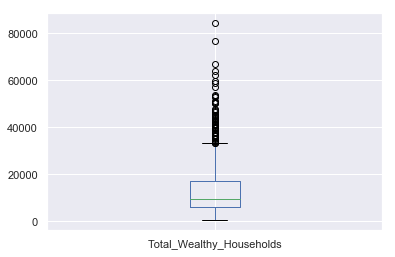

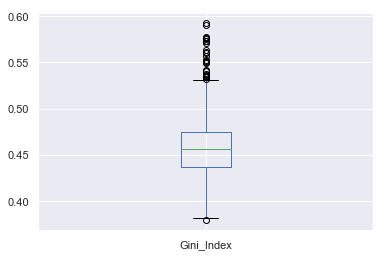

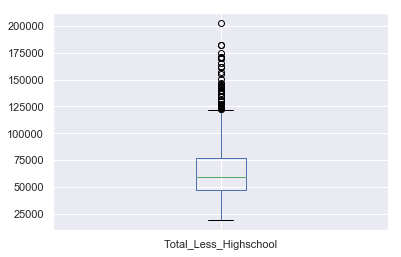

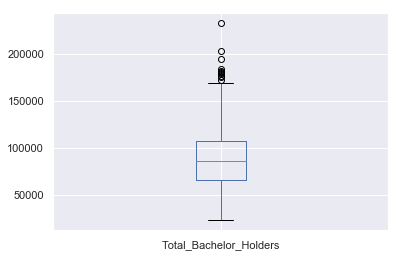

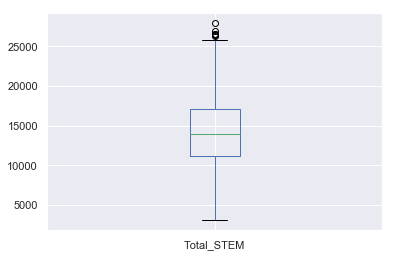

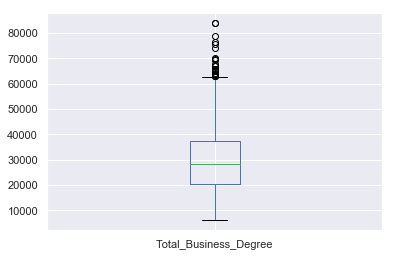

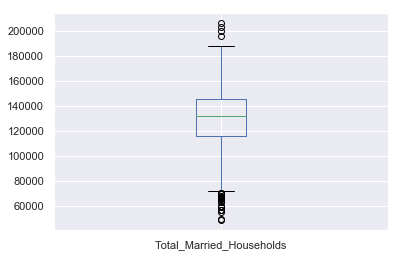

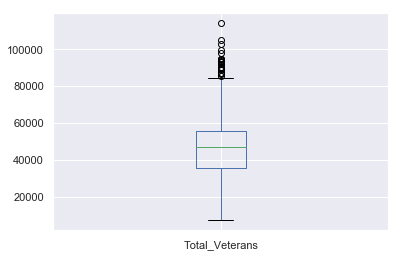

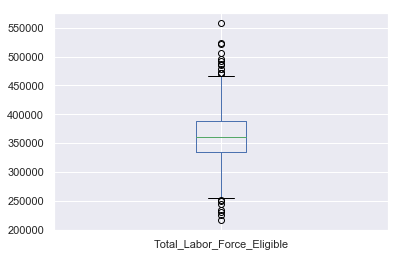

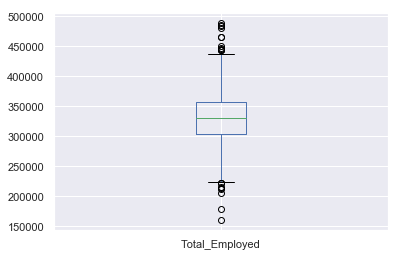

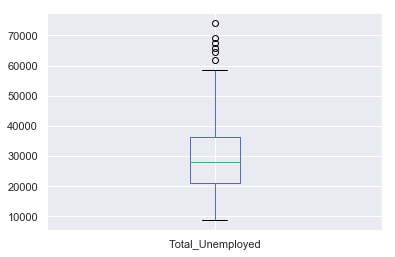

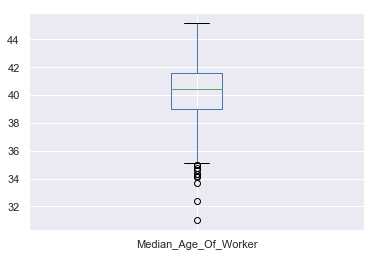

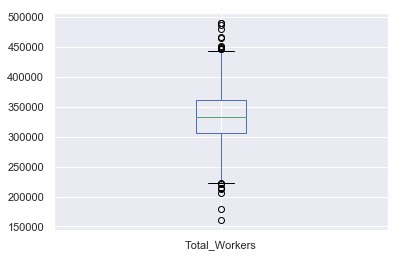

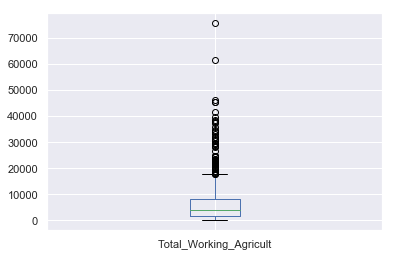

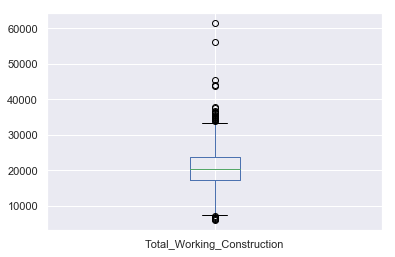

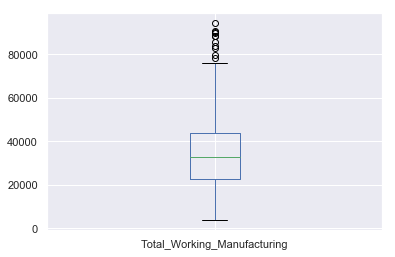

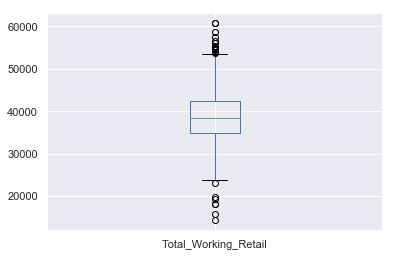

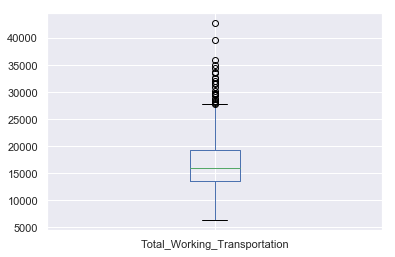

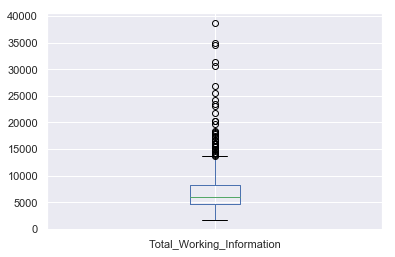

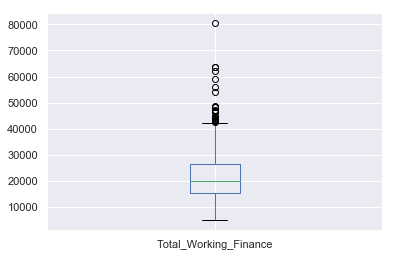

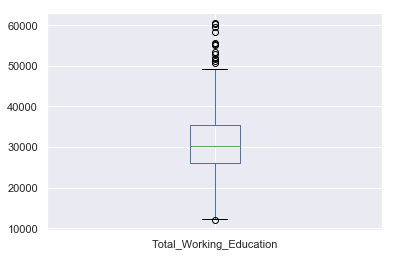

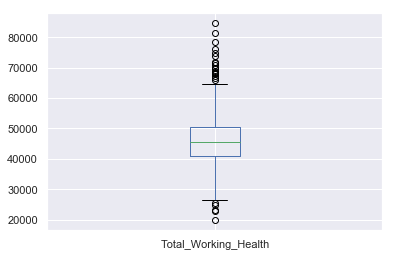

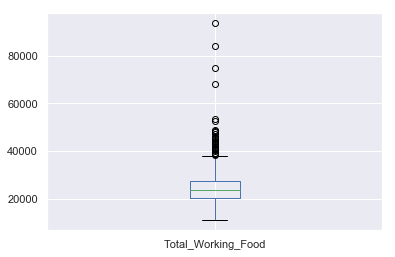

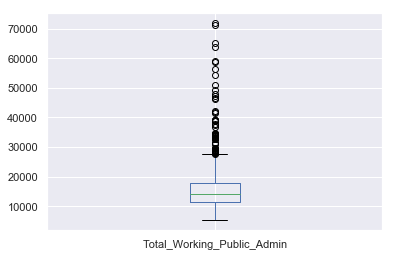

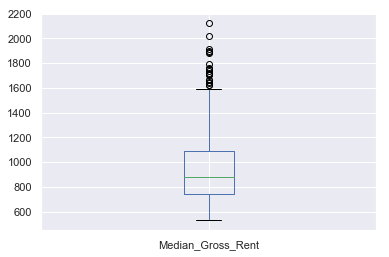

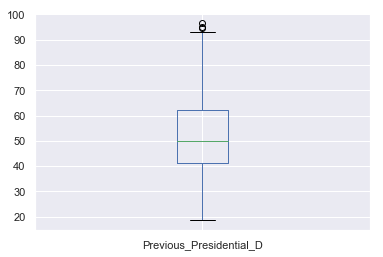

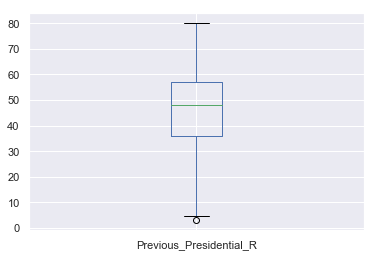

In [11]:
#Boxplots of all continuous variables as individual graphs
for i in election_df.columns[3:-1]:
    election_df.boxplot(column=i)
    plt.show()

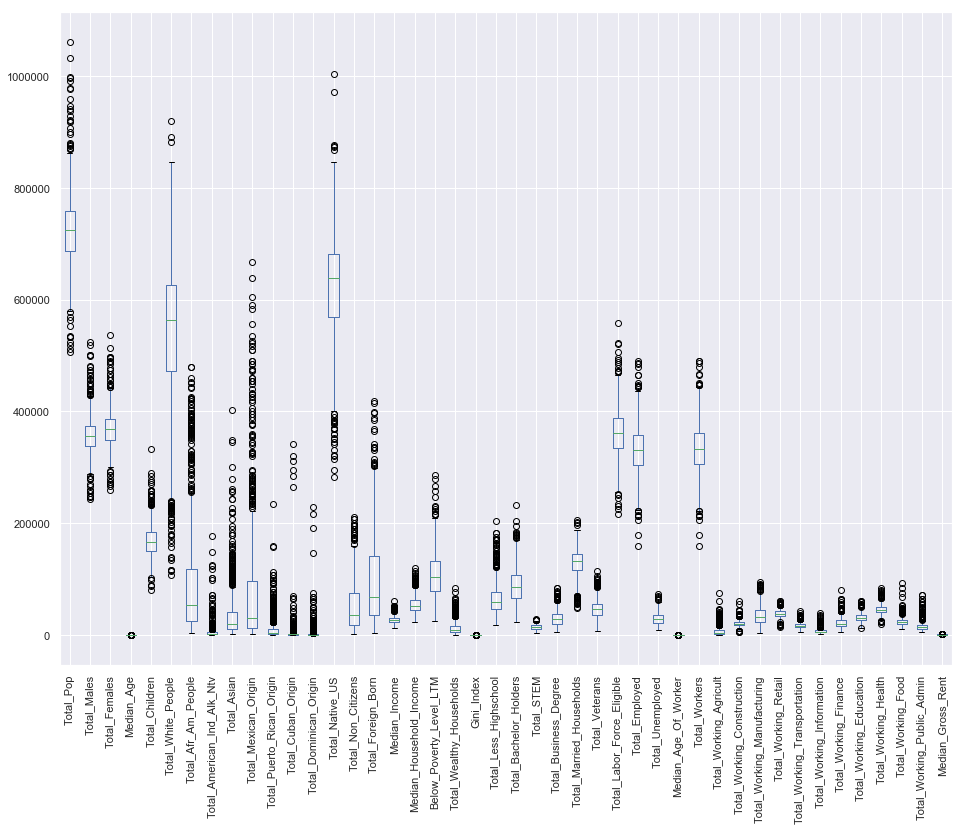

In [12]:
#A Boxplot of all continuous variables in one graph
election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent']].boxplot(figsize = (16,12), rot= 90)

## 3. A Function To Plot The Confusion Matrix

In [13]:
#This function will be used to create confusion matrices for each model where appropriate
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    classes = ['Did Not Vote Republican', 'Voted Republican']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 4. Feature Engineering

In [14]:
election_df.describe()

Total_Pop    Total_Males  Total_Females  Median_Age  Total_Children  \
count  8.600000e+02     860.000000     860.000000  860.000000      860.000000   
mean   7.268451e+05  357600.737209  369244.387209   37.820233   169483.191860   
std    6.619435e+04   34433.479928   33183.422698    3.590825    29622.251731   
min    5.060360e+05  244165.000000  259717.000000   26.600000    79905.000000   
25%    6.869985e+05  338342.750000  349492.750000   35.700000   150886.250000   
50%    7.251775e+05  356798.000000  367634.500000   37.800000   166010.500000   
75%    7.589910e+05  374238.500000  386822.250000   40.025000   183537.500000   
max    1.060651e+06  524241.000000  536410.000000   53.500000   333258.000000   

       Total_White_People  Total_Afr_Am_People  Total_American_Ind_Alk_Ntv  \
count          860.000000           860.000000                  860.000000   
mean        533979.023256         92016.222093                 5950.669767   
std         135143.070581        101111.608945                14154.258727   
min         108156.000000          3031.000000                  204.000000   
25%         471771.000000         25725.000000                 1466.500000   
50%         562842.000000         52870.000000                 2542.000000   
75%         626446.000000        117343.500000                 5004.000000   
max         918701.000000        480259.000000               177468.000000   

         Total_Asian  Total_Mexican_Origin  ...  Total_Working_Information  \
count     860.000000            860.000000  ...                 860.000000   
mean    37313.330233          80489.416279  ...                7027.823256   
std     46828.288462         115513.394277  ...                3957.953694   
min      1582.000000           1644.000000  ...                1572.000000   
25%     11112.250000          13003.750000  ...                4568.000000   
50%     19595.500000          29654.500000  ...                6045.000000   
75%     41617.000000          96621.750000  ...                8227.500000   
max    402466.000000         667403.000000  ...               38750.000000   

       Total_Working_Finance  Total_Working_Education  Total_Working_Health  \
count             860.000000               860.000000            860.000000   
mean            21897.318605             30998.567442          45973.329070   
std              8880.305939              7304.605726           8275.721264   
min              4898.000000             11937.000000          19790.000000   
25%             15569.250000             26153.750000          40786.000000   
50%             20156.500000             30256.500000          45551.000000   
75%             26312.750000             35481.500000          50479.500000   
max             80628.000000             60628.000000          84767.000000   

       Total_Working_Food  Total_Working_Public_Admin  Median_Gross_Rent  \
count          860.000000                  860.000000         860.000000   
mean         24927.781395                16047.937209         941.208140   
std           7152.465737                 8063.942992         263.963379   
min          10929.000000                 5196.000000         528.000000   
25%          20498.250000                11266.750000         740.750000   
50%          23704.500000                14209.000000         875.500000   
75%          27580.500000                17775.500000        1092.750000   
max          93824.000000                71974.000000        2126.000000   

       Previous_Presidential_D  Previous_Presidential_R  \
count               860.000000               860.000000   
mean                 52.310209                46.105140   
std                  15.197163                15.198029   
min                  18.500000                 3.000000   
25%                  41.200000                36.000000   
50%                  50.000000                48.200000   
75%                  62.350000                57.200000   
max  

In [15]:
#I create a second dataframe made of my engineered features and compare the results of
#each dataframe
election_df_feature_engineering = election_df.copy()
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Informat

In [16]:
#Create booleans if more than ten percent of a district's labor force work in a specific industry
election_df_feature_engineering['Ten_Percent_Manufacturing'] = np.where(election_df_feature_engineering['Total_Working_Manufacturing']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Manufacturing.value_counts())

election_df_feature_engineering['Ten_Percent_Agricult'] = np.where(election_df_feature_engineering['Total_Working_Agricult']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Agricult.value_counts())

election_df_feature_engineering['Ten_Percent_Construction'] = np.where(election_df_feature_engineering['Total_Working_Construction']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Construction.value_counts())

election_df_feature_engineering['Ten_Percent_Retail'] = np.where(election_df_feature_engineering['Total_Working_Retail']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Retail.value_counts())

election_df_feature_engineering['Ten_Percent_Information'] = np.where(election_df_feature_engineering['Total_Working_Information']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Information.value_counts())

election_df_feature_engineering['Ten_Percent_Transportation'] = np.where(election_df_feature_engineering['Total_Working_Transportation']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Transportation.value_counts())

election_df_feature_engineering['Ten_Percent_Finance'] = np.where(election_df_feature_engineering['Total_Working_Finance']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Finance.value_counts())

election_df_feature_engineering['Ten_Percent_Education'] = np.where(election_df_feature_engineering['Total_Working_Education']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Education.value_counts())

election_df_feature_engineering['Ten_Percent_Health'] = np.where(election_df_feature_engineering['Total_Working_Health']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Health.value_counts())

election_df_feature_engineering['Ten_Percent_Food'] = np.where(election_df_feature_engineering['Total_Working_Food']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Food.value_counts())


#Drops the columns that the above booleans were derived from
election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)


0    438
1    422
Name: Ten_Percent_Manufacturing, dtype: int64
0    847
1     13
Name: Ten_Percent_Agricult, dtype: int64
0    846
1     14
Name: Ten_Percent_Construction, dtype: int64
1    771
0     89
Name: Ten_Percent_Retail, dtype: int64
0    860
Name: Ten_Percent_Information, dtype: int64
0    853
1      7
Name: Ten_Percent_Transportation, dtype: int64
0    803
1     57
Name: Ten_Percent_Finance, dtype: int64
0    605
1    255
Name: Ten_Percent_Education, dtype: int64
1    826
0     34
Name: Ten_Percent_Health, dtype: int64
0    797
1     63
Name: Ten_Percent_Food, dtype: int64


CD_Id_Year                                      District_Name State  \
0    CT-01-2016  Congressional District 1 (114th Congress), Con...    CT   
1    CT-02-2016  Congressional District 2 (114th Congress), Con...    CT   
2    CT-03-2016  Congressional District 3 (114th Congress), Con...    CT   
3    CT-04-2016  Congressional District 4 (114th Congress), Con...    CT   
4    CT-05-2016  Congressional District 5 (114th Congress), Con...    CT   
5    DE-AL-2016  Congressional District (at Large) (114th Congr...    DE   
6    DC-98-2016  Delegate District (at Large) (114th Congress),...    DC   
7    FL-01-2016  Congressional District 1 (114th Congress), Flo...    FL   
8    FL-02-2016  Congressional District 2 (114th Congress), Flo...    FL   
9    FL-03-2016  Congressional District 3 (114th Congress), Flo...    FL   
10   FL-04-2016  Congressional District 4 (114th Congress), Flo...    FL   
11   FL-05-2016  Congressional District 5 (114th Congress), Flo...    FL   
12   FL-06-2016  Congressional District 6 (114th Congress), Flo...    FL   
13   FL-07-2016  Congressional District 7 (114th Congress), Flo...    FL   
14   FL-08-2016  Congressional District 8 (114th Congress), Flo...    FL   
15   FL-09-2016  Congressional District 9 (114th Congress), Flo...    FL   
16   FL-10-2016  Congressional District 10 (114th Congress), Fl...    FL   
17   FL-11-2016  Congressional District 11 (114th Congress), Fl...    FL   
18   FL-12-2016  Congressional District 12 (114th Congress), Fl...    FL   
19   FL-13-2016  Congressional District 13 (114th Congress), Fl...    FL   
20   FL-14-2016  Congressional District 14 (114th Congress), Fl...    FL   
21   FL-15-2016  Congressional District 15 (114th Congress), Fl...    FL   
22   FL-16-2016  Congressional District 16 (114th Congress), Fl...    FL   
23   FL-17-2016  Congressional District 17 (114th Congress), Fl...    FL   
24   FL-18-2016  Congressional District 18 (114th Congress), Fl...    FL   
25   FL-19-2016  Congressional District 19 (114th Congress), Fl...    FL   
26   FL-20-2016  Congressional District 20 (114th Congress), Fl...    FL   
27   FL-21-2016  Congressional District 21 (114th Congress), Fl...    FL   
28   FL-22-2016  Congressional District 22 (114th Congress), Fl...    FL   
29   FL-23-2016  Congressional District 23 (114th Congress), Fl...    FL   
..          ...                                                ...   ...   
830  VA-03-2012  Congressional District 3 (112th Congress), Vir...    VA   
831  VA-04-2012  Congressional District 4 (112th Congress), Vir...    VA   
832  VA-05-2012  Congressional District 5 (112th Congress), Vir...    VA   
833  VA-06-2012  Congressional District 6 (112th Congress), Vir...    VA   
834  VA-07-2012  Congressional District 7 (112th Congress), Vir...    VA   
835  VA-08-2012  Congressional District 8 (112th Congress), Vir...    VA   
836  VA-09-2012  Congressional District 9 (112th Congress), Vir...    VA   
837  VA-10-2012  Congressional District 10 (112th Congress), Vi...    VA   
838  VA-11-2012  Congressional District 11 (112th Congress), Vi...    VA   
839  WA-01-2012  Congressional District 1 (112th Congress), Was...    WA   
840  WA-02-2012  Congressional District 2 (112th Congress), Was...    WA   
841  WA-03-2012  Congressional District 3 (112th Congress), Was...    WA   
842  WA-04-2012  Congressional District 4 (112th Congress), Was...    WA   
843  WA-05-2012  Congressional District 5 (112th Congress), Was...    WA   
844  WA-06-2012  Congressional District 6 (112th Congress), Was...    WA   
845  WA-07-2012  Congressional District 7 (112th Congress), Was...    WA   
846  WA-08-2012  Congressional District 8 (112th Congress), Was...    WA   
847  WA-09-2012  Congressional District 9 (112th Congress), Was...    WA   
848  WV-01-2012  Congressional District 1 (112th Congress), Wes...    WV   
849  WV-02-2012  Congressional District 2 (112th Congress), Wes...    WV   
850  WV-03-2012  Congressional District 3 (112th Cong

In [17]:
#Drop the original columns that the threshold columns were created from
election_df_feature_engineering = election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)

#Drop the information boolean column because no district contains more than ten
#percent of the labor force working in that field
election_df_feature_engineering = election_df_feature_engineering.drop(['Ten_Percent_Information'], axis=1)

In [18]:
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R',
       'Target_Presidential_R_bool', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Per

In [19]:
#Reorganize the second dataframe
election_df_feature_engineering = election_df_feature_engineering[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent_Transportation',
       'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
       'Ten_Percent_Food', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 5. Initial Regression - Without Feature Engineering

In [20]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_1 = election_df.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

#y will hold the target variable
y_log_model_1 = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [21]:
#Split the data into a train and test set
X_train_log_model_1, X_test_log_model_1, y_train_log_model_1, y_test_log_model_1 = train_test_split(X_log_model_1, y_log_model_1, random_state=1, )

In [22]:
#Fit the model and view the coefficients
log_model_1 = LogisticRegression(C=1e9)
log_model_1.fit(X_train_log_model_1, y_train_log_model_1)
zip(X_train_log_model_1.columns, log_model_1.coef_[0])
log_model_1.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[-4.53877083e-05,  2.17186029e-05, -6.71063113e-05,
        -3.63146324e-04,  3.74051973e-05,  1.27196335e-05,
         6.18345140e-06,  1.09501521e-05,  8.27477576e-06,
        -1.29196304e-05,  9.19537111e-06, -9.80918820e-06,
        -1.21455044e-05,  5.66057174e-05, -5.17280380e-05,
         8.14219317e-05, -1.04959764e-04, -4.60832220e-06,
        -1.12981363e-06, -6.01679897e-06,  6.42623628e-06,
         3.16568478e-05,  1.06573520e-05, -2.88004420e-05,
         6.32992449e-05,  5.49880059e-06,  1.93996016e-05,
        -1.76057584e-05,  2.67457083e-05, -4.43514668e-05,
        -1.97136255e-04, -4.10198236e-05,  6.12329892e-05,
         3.54898994e-05,  3.38815934e-05,  9.59155375e-05,
         3.60296357e-05, -4.91383278e-05,  3.24078167e-05,
         3.85006186e-05, -5.84562924e-05,  4.35350745e-05,
         1.82246342e-05, -6.55817602e-04, -1.70273528e-02,
         1.75505000e-02]])

In [23]:
#Makes predictions on the train and test set
y_pred_class_log_model_1_train = log_model_1.predict(X_train_log_model_1)


#Calculate the model's accuracy and f1
print("The training accuracy is: " + str(metrics.accuracy_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

print("The training f1 score is: " + str(metrics.f1_score(y_train_log_model_1, y_pred_class_log_model_1_train)))

The training accuracy is: 0.8837209302325582
The training f1 score is: 0.8908296943231442


In [24]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_1 = log_model_1.predict(X_test_log_model_1)

#Calculates the model's accuracy and f1
print("The testing accuracy is: " + str(metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1)))

print("The testing f1 score is: " + str(metrics.f1_score(y_test_log_model_1, y_pred_class_log_model_1)))

The testing accuracy is: 0.8093023255813954
The testing f1 score is: 0.8110599078341014


In [25]:
#Save confusion matrix and slice into four pieces
confusion_log_model_1 = metrics.confusion_matrix(y_test_log_model_1, y_pred_class_log_model_1)
TP_log_model_1 = confusion_log_model_1[1][1]
TN_log_model_1 = confusion_log_model_1[0][0]
FP_log_model_1 = confusion_log_model_1[0][1]
FN_log_model_1 = confusion_log_model_1[1][0]

print('Log Model 1 Confusion Matrix:')
print ('True Positives:', TP_log_model_1)
print ('True Negatives:', TN_log_model_1)
print ('False Positives:', FP_log_model_1)
print ('False Negatives:', FN_log_model_1)

Log Model 1 Confusion Matrix:
True Positives: 88
True Negatives: 86
False Positives: 22
False Negatives: 19


Confusion Matrix, without normalization


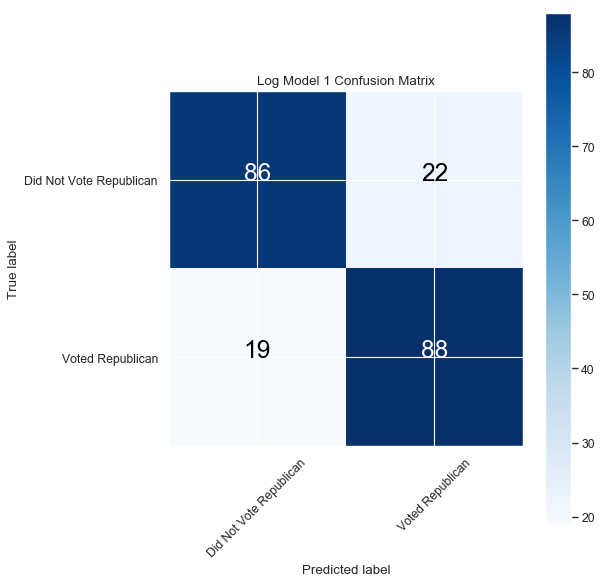

In [26]:
#Plot the confusion matrix
plot_confusion_matrix(confusion_log_model_1,
                          normalize=False,
                          title='Log Model 1 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 6. Initial Regression - With Feature Engineering

In [27]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#using the dataframe with feature engineering

#Split data to be used in the models between the target variable and features

# X will take every dependent variable but the target and other index variables
X_log_model_2 = election_df_feature_engineering.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name','State'], axis = 1) 

# Create target variable
y_log_model_2 = election_df_feature_engineering['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [28]:
#Split the data into a train and test set
X_train_log_model_2, X_test_log_model_2, y_train_log_model_2, y_test_log_model_2 = train_test_split(X_log_model_2, y_log_model_2, random_state=1)

In [29]:
#Fit the model and view the coefficients
log_model_2 = LogisticRegression(C=1e9)
log_model_2.fit(X_train_log_model_2, y_train_log_model_2)
zip(X_train_log_model_2.columns, log_model_2.coef_[0])
log_model_2.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[-2.83835973e-05,  3.03793218e-05, -5.87629200e-05,
        -1.00359304e-03,  2.25173640e-05,  9.00797406e-06,
         4.94785617e-06,  6.42260746e-06,  4.39742908e-06,
        -1.02441226e-05,  4.99200278e-06, -1.27127163e-05,
        -7.88396481e-06,  3.90588085e-05, -3.55178829e-05,
         6.06005349e-05, -1.08555395e-04,  2.89184302e-06,
        -2.32849156e-06, -3.58590325e-05,  2.76182501e-05,
         1.73155834e-05,  2.92944905e-06, -7.49596473e-05,
         4.32497099e-05,  8.95951889e-06,  3.34378957e-06,
        -2.01839852e-05,  3.42618186e-06, -2.36101673e-05,
        -4.65593540e-04,  1.03281379e-05, -3.03816780e-04,
        -2.22653560e-05, -3.41198275e-05,  2.24719524e-04,
        -3.62503174e-06,  1.18574120e-04, -2.09568306e-04,
        -7.48967357e-05,  1.85543658e-04, -1.00838994e-03,
        -6.36451333e-02,  6.63639843e-02]])

In [30]:
#Makes predictions on the train and test set
y_pred_class_log_model_2_train = log_model_2.predict(X_train_log_model_2)


#Calculate the model's accuracy and f1 score
print("The training accuracy is: ", metrics.accuracy_score(y_train_log_model_2, y_pred_class_log_model_2_train))

print("The training f1 score is: ", metrics.f1_score(y_train_log_model_2, y_pred_class_log_model_2_train))

The training accuracy is:  0.9348837209302325
The training f1 score is:  0.9375


In [31]:
#Class predictions on the test set (not predicted probabilities)
y_pred_class_log_model_2 = log_model_2.predict(X_test_log_model_2)

#Calculate the model's accuracy and f1 score
print("The testing accuracy is: ", metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2))

print("The testing f1 score is: ", metrics.f1_score(y_test_log_model_2, y_pred_class_log_model_2))

The testing accuracy is:  0.8976744186046511
The testing f1 score is:  0.8990825688073394


In [32]:
#Save confusion matrix and slice into four pieces
confusion_log_model_2 = metrics.confusion_matrix(y_test_log_model_2, y_pred_class_log_model_2)
TP_log_model_2 = confusion_log_model_1[1][1]
TN_log_model_2 = confusion_log_model_1[0][0]
FP_log_model_2 = confusion_log_model_1[0][1]
FN_log_model_2 = confusion_log_model_1[1][0]

print('Log Model 2 Confusion Matrix:')
print ('True Positives:', TP_log_model_2)
print ('True Negatives:', TN_log_model_2)
print ('False Positives:', FP_log_model_2)
print ('False Negatives:', FN_log_model_2)

Log Model 2 Confusion Matrix:
True Positives: 88
True Negatives: 86
False Positives: 22
False Negatives: 19


Confusion Matrix, without normalization


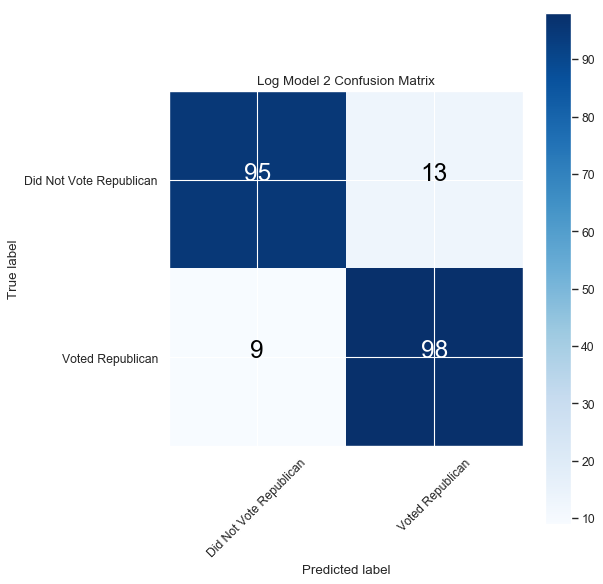

In [33]:
#Plot the confusion Matrix
plot_confusion_matrix(confusion_log_model_2,
                          normalize=False,
                          title='Log Model 2 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 7. Logstic Model Grid Search

In [34]:
#The following is a function that resets the data for future use
def reset_data(df_to_use = None):
    
    if df_to_use == 'engineered':
        
        df = election_df_feature_engineering
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent',
                         'Previous_Presidential_D', 'Previous_Presidential_R']
    else:
        
        df = election_df
        
        features_list = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D',
                         'Previous_Presidential_R']
    
    y = df.Target_Presidential_R_bool
    X = df[features_list]
    
    return train_test_split(X, y, random_state=1, test_size = 0.2)


In [35]:
#Splits the data for the logistic model gridsearch, using the standard features
X_train_log_model_3, X_test_log_model_3, y_train_log_model_3, y_test_log_model_3 =  reset_data()

sc_log_model_3=StandardScaler()
X_train_scaled_log_model_3= sc_log_model_3.fit_transform(X_train_log_model_3)
X_test_scaled_log_model_3 = sc_log_model_3.transform(X_test_log_model_3)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [36]:
# Creates logistic regression model
log_model_3 = linear_model.LogisticRegression()

In [37]:
# Creates regularization penalty parameters
penalty = ['l1', 'l2']

# Creates regularization hyperparameters
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10]

# Creates hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [38]:
# Creates a grid search using 5-fold cross validation
clf_gs_log_model_3 = GridSearchCV(log_model_3, hyperparameters, cv=5, scoring= "f1") 

In [39]:
# Fits grid search to the training data
log_model_3 = clf_gs_log_model_3.fit(X_train_scaled_log_model_3, y_train_log_model_3) 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
# View best hyperparameters
print('Best Penalty:', log_model_3.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_3.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.5


In [41]:
#Make predictions for scoring purposes
y_pred_train_log_model_3 = log_model_3.best_estimator_.predict(X_train_scaled_log_model_3)

y_pred_test_log_model_3 = log_model_3.best_estimator_.predict(X_test_scaled_log_model_3)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_train_log_model_3, y_pred_train_log_model_3))
print("Training F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_train_log_model_3, y_pred_train_log_model_3))
print("")
print("Testing Accuracy for Log Model 3 (GS Standard Features):", metrics.accuracy_score(y_test_log_model_3, y_pred_test_log_model_3))
print("Testing F1 Score for Log Model 3 (GS Standard Features):", metrics.f1_score(y_test_log_model_3, y_pred_test_log_model_3))

Training Accuracy for Log Model 3 (GS Standard Features): 0.9694767441860465
Training F1 Score for Log Model 3 (GS Standard Features): 0.9703808180535967

Testing Accuracy for Log Model 3 (GS Standard Features): 0.9011627906976745
Testing F1 Score for Log Model 3 (GS Standard Features): 0.9081081081081082


In [42]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_3 = list(zip(list(X_train_log_model_3.columns), log_model_3.best_estimator_.coef_[0]))

model_params_log_model_3.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_3[:10]

[('Previous_Presidential_R', 7.612860752332177),
 ('Total_Non_Citizens', -0.731589855668359),
 ('Total_Working_Retail', 0.649145407430689),
 ('Total_Bachelor_Holders', -0.5198878202330314),
 ('Total_Wealthy_Households', -0.3219205232414764),
 ('Total_Mexican_Origin', -0.30428750009120775),
 ('Total_Working_Finance', -0.2953191539890878),
 ('Total_Working_Manufacturing', 0.24465873125668874),
 ('Median_Gross_Rent', -0.22644006399324282),
 ('Total_Working_Transportation', 0.1368278802839304)]

<Figure size 432x288 with 0 Axes>

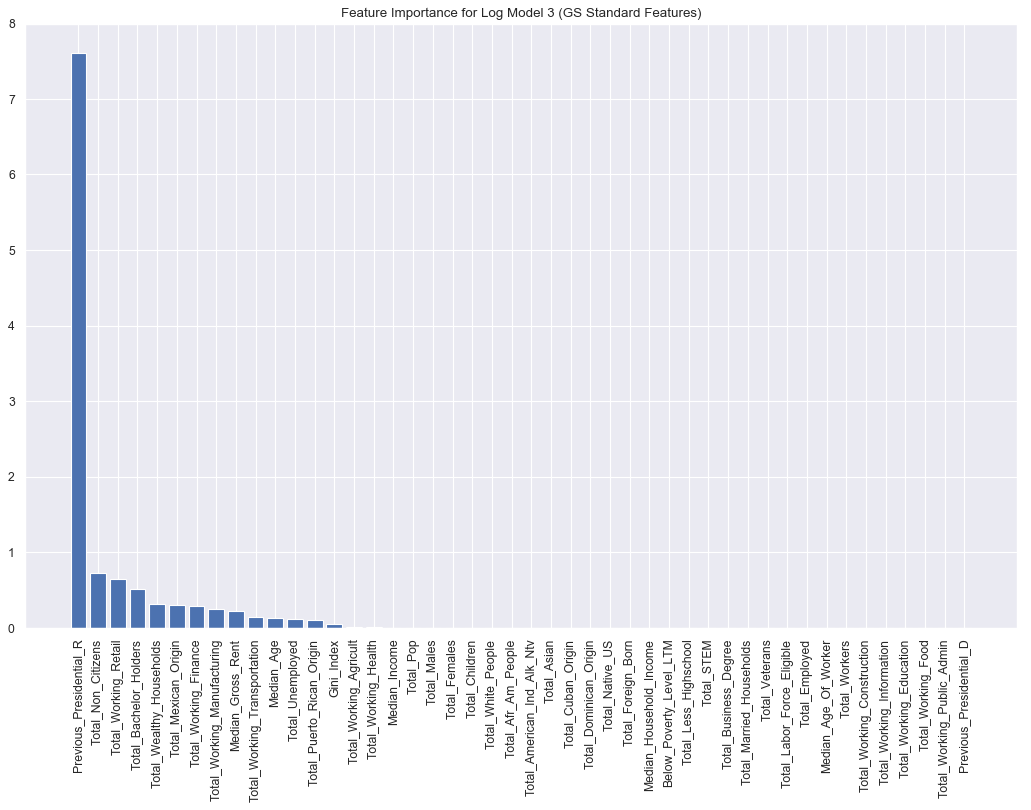

In [43]:
#Plots the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_3 = [i[0] for i in model_params_log_model_3]

feature_weights_log_model_3 = [abs(i[1]) for i in model_params_log_model_3]

# Creates the plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Creates the plot title
plt.title("Feature Importance for Log Model 3 (GS Standard Features)")

# Add bars
plt.bar(model_features_log_model_3, feature_weights_log_model_3)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

In [44]:
# View confusion matrix and slice into four pieces

confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)
TP_log_model_3 = confusion_log_model_3[1][1]
TN_log_model_3 = confusion_log_model_3[0][0]
FP_log_model_3 = confusion_log_model_3[0][1]
FN_log_model_3 = confusion_log_model_3[1][0]

print('Log Model 3 Confusion Matrix:')
print ('True Positives:', TP_log_model_3)
print ('True Negatives:', TN_log_model_3)
print ('False Positives:', FP_log_model_3)
print ('False Negatives:', FN_log_model_3)

Log Model 3 Confusion Matrix:
True Positives: 84
True Negatives: 71
False Positives: 9
False Negatives: 8


Confusion Matrix, without normalization


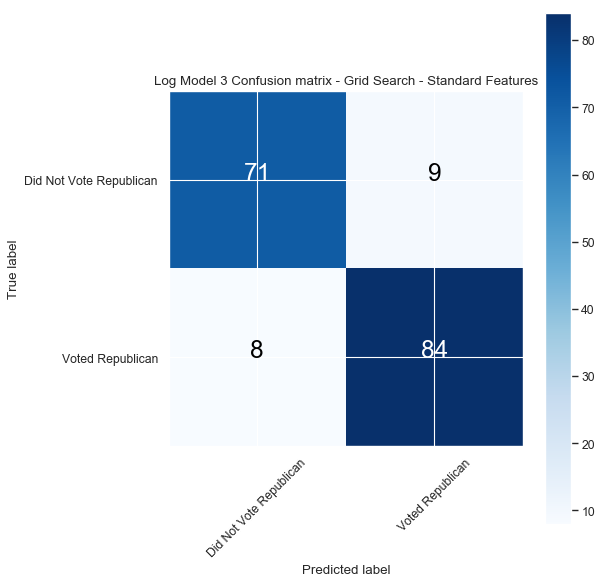

In [45]:
#Plots the confusion matrix visualization
confusion_log_model_3 = metrics.confusion_matrix(y_test_log_model_3, y_pred_test_log_model_3)

plot_confusion_matrix(confusion_log_model_3, title='Log Model 3 Confusion matrix - Grid Search - Standard Features')


## 8. Logistic Model Grid Search With Engineered Features

In [47]:
#Splits the data for the logistic model gridsearch, using the engineered features
X_train_log_model_4, X_test_log_model_4, y_train_log_model_4, y_test_log_model_4 =  reset_data('engineered')

sc_log_model_4=StandardScaler()
X_train_scaled_log_model_4= sc_log_model_4.fit_transform(X_train_log_model_4)
X_test_scaled_log_model_4 = sc_log_model_4.transform(X_test_log_model_4)

# Create logistic regression model
log_model_4 = linear_model.LogisticRegression()

# Create grid search using 5-fold cross validation, same parameters as before
clf_gs_log_model_4 = GridSearchCV(log_model_4, hyperparameters, cv=5, scoring= "f1") 

# Fit grid search
log_model_4 = clf_gs_log_model_4.fit(X_train_scaled_log_model_4, y_train_log_model_4)



/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision',

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
# View best hyperparameters
print('Best Penalty:', log_model_4.best_estimator_.get_params()['penalty'])
print('Best C:', log_model_4.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.5


In [50]:
#Make predictions for scoring purposes

y_pred_train_log_model_4 = log_model_4.best_estimator_.predict(X_train_scaled_log_model_4)

y_pred_test_log_model_4 = log_model_4.best_estimator_.predict(X_test_scaled_log_model_4)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_train_log_model_4, y_pred_train_log_model_4))
print("Training F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_train_log_model_4, y_pred_train_log_model_4))
print("")
print("Testing Accuracy for Log Model 4 (GS Engineered Features):", metrics.accuracy_score(y_test_log_model_4, y_pred_test_log_model_4))
print("Testing F1 Score for Log Model 4 (GS Engineered Features):", metrics.f1_score(y_test_log_model_4, y_pred_test_log_model_4))

Training Accuracy for Log Model 4 (GS Engineered Features): 0.9636627906976745
Training F1 Score for Log Model 4 (GS Engineered Features): 0.9646393210749646

Testing Accuracy for Log Model 4 (GS Engineered Features): 0.9011627906976745
Testing F1 Score for Log Model 4 (GS Engineered Features): 0.9081081081081082


In [51]:
# Sorts feature importances in descending order and displays the top 10

model_params_log_model_4 = list(zip(list(X_train_log_model_4.columns), log_model_4.best_estimator_.coef_[0]))

model_params_log_model_4.sort(key = lambda x: abs(x[1]), reverse=True)
model_params_log_model_4[:10]

[('Previous_Presidential_R', 7.392927703736311),
 ('Ten_Percent_Retail', 0.5836652704551201),
 ('Total_Mexican_Origin', -0.5253334563799198),
 ('Median_Gross_Rent', -0.4667370779025399),
 ('Total_Native_US', 0.3736645137953438),
 ('Gini_Index', -0.33817507091071297),
 ('Total_Bachelor_Holders', -0.32760511852629004),
 ('Total_Wealthy_Households', -0.22732115236376937),
 ('Total_Non_Citizens', -0.11021299799202575),
 ('Median_Age', 0.107833232626264)]

<Figure size 432x288 with 0 Axes>

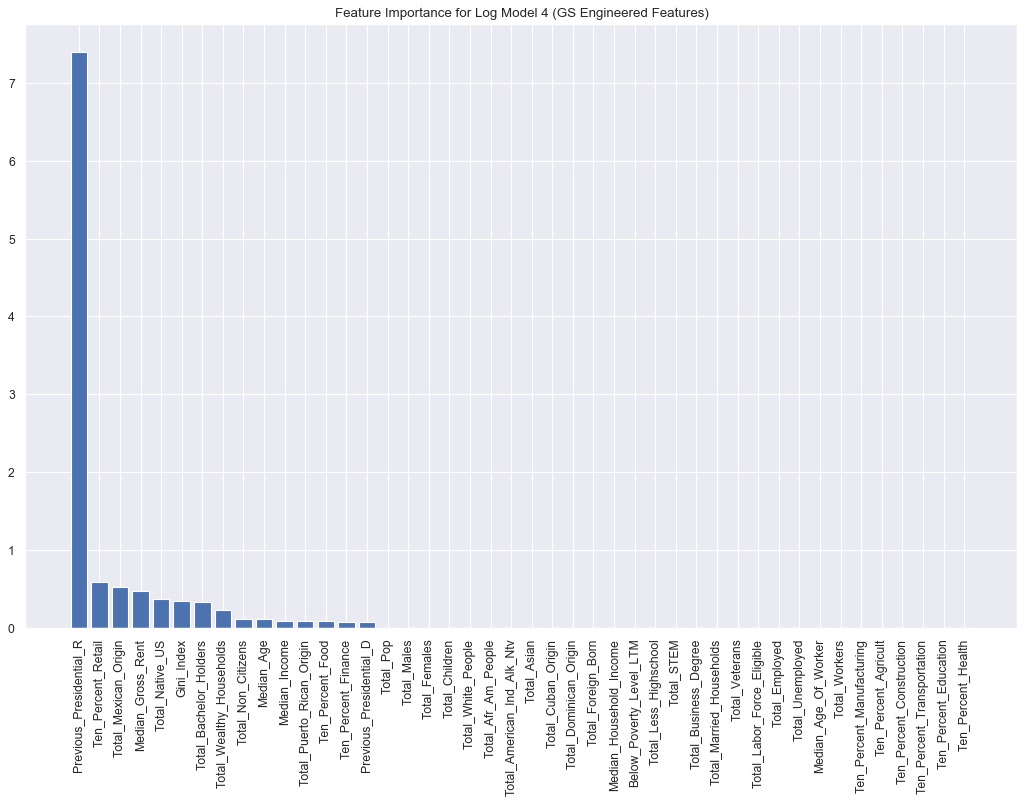

In [52]:
#Plot the parameter importance

# Rearrange feature names so they match the sorted feature importances
model_features_log_model_4 = [i[0] for i in model_params_log_model_4]

feature_weights_log_model_4 = [abs(i[1]) for i in model_params_log_model_4]

# Create plot

plt.figure()
figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# Create plot title
plt.title("Feature Importance for Log Model 4 (GS Engineered Features)")

# Add bars
plt.bar(model_features_log_model_4, feature_weights_log_model_4)

# Add feature names as x-axis labels
plt.xticks(rotation=90)

# Show plot
plt.show()

Confusion Matrix, without normalization


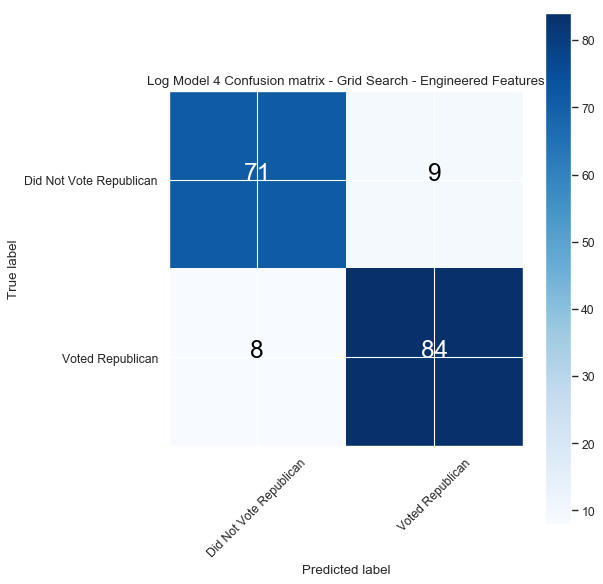

In [53]:
#View the confusion matrix
confusion_log_model_4 = metrics.confusion_matrix(y_test_log_model_4, y_pred_test_log_model_4)
plot_confusion_matrix(confusion_log_model_4, title='Log Model 4 Confusion matrix - Grid Search - Engineered Features')

## 9. Logstic Model Grid Search On The Standard Set- With Polynomials

In [54]:
#Create a pipeline for a polynomial grid search
pipe_lr_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

In [55]:
#Sets up the parameters to search through
penalty_param_range_lr_poly = [1.0, 0.5, 0.1, .01]

grid_params_lr_poly = [{'clf__penalty': ['l1', 'l2'], 'clf__C': penalty_param_range_lr_poly, 'clf__solver': ['liblinear']}] 



In [56]:
#Splits the data for the polynomial logistic model gridsearch, using the standard features
X_train_log_model_5, X_test_log_model_5, y_train_log_model_5, y_test_log_model_5 =  reset_data()

sc_log_model_5=StandardScaler()
X_train_scaled_log_model_5= sc_log_model_5.fit_transform(X_train_log_model_5)
X_test_scaled_log_model_5 = sc_log_model_5.transform(X_test_log_model_5)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [57]:
#Fits the model
log_model_5 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10, verbose=5)
log_model_5.fit(X_train_log_model_5, y_train_log_model_5)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9315068493150684, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9315068493150684, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.958904109589041, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9577464788732395, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9714285714285714, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.958904109589041, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9411764705882354, total=   1.7s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9722222222222222, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9855072463768115, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9565217391304348, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l2, clf__solver=liblinear ..

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9577464788732395, total=   6.5s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9714285714285714, total=   6.6s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9444444444444445, total=   6.8s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9411764705882354, total=   7.3s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9577464788732395, total=   6.6s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9859154929577464, total=   7.3s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.1min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [58]:
#Loading the saved model with pickle
#log_model_5_pkl = open('./Classification_Models_After_log_model_5.pkl', 'rb')
#log_model_5 = pickle.load(log_model_5_pkl)
#print("Loaded log_model_5 Pickle :: ", log_model_5)

In [59]:
# Best params
print('Best params: %s' % log_model_5.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_5 = log_model_5.predict(X_test_log_model_5)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.956
Test set F1 score for best params: 0.9290 


In [60]:
#Make predictions for scoring purposes
y_pred_train_log_model_5 = log_model_5.predict(X_train_log_model_5)

# Model accuracy and f1 scores
print("Training Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_train_log_model_5, y_pred_train_log_model_5))
print("Training F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_train_log_model_5, y_pred_train_log_model_5))
print("")
print("Testing Accuracy for Log Model 5 (GS Polynomials Standard Features):", accuracy_score(y_test_log_model_5, y_pred_test_log_model_5))
print("Testing F1 Score for Log Model 5 (GS Polynomials Standard Features):", f1_score(y_test_log_model_5, y_pred_test_log_model_5))

Training Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9883720930232558
Training F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9886685552407932

Testing Accuracy for Log Model 5 (GS Polynomials Standard Features): 0.9244186046511628
Testing F1 Score for Log Model 5 (GS Polynomials Standard Features): 0.9289617486338797


Confusion Matrix, without normalization


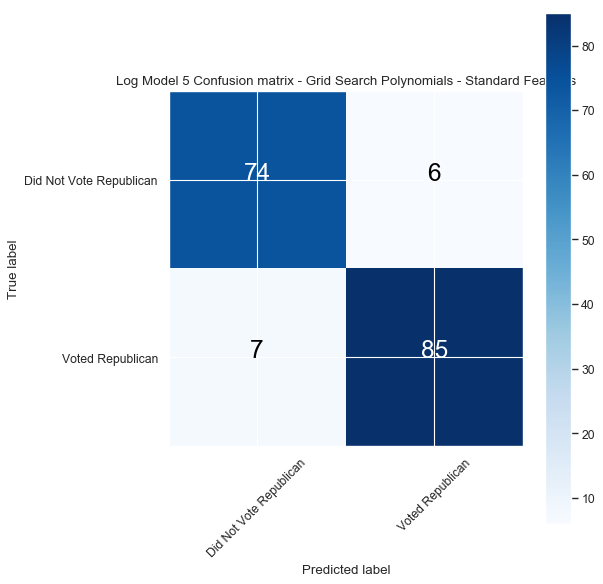

In [61]:
#View the confusion matrix
confusion_log_model_5 = metrics.confusion_matrix(y_test_log_model_5, y_pred_test_log_model_5)
plot_confusion_matrix(confusion_log_model_5, title='Log Model 5 Confusion matrix - Grid Search Polynomials - Standard Features')

In [62]:
#Run this code to save the model data
#make_pickle(log_model_5, 'log_model_5')

## 10. Logstic Model Grid Search On The Engineered Set- With Polynomials

In [63]:
#Splits the data for the polynomial logistic model gridsearch, using the engineered features
X_train_log_model_6, X_test_log_model_6, y_train_log_model_6, y_test_log_model_6 =  reset_data('engineered')

sc_log_model_6=StandardScaler()
X_train_scaled_log_model_6= sc_log_model_6.fit_transform(X_train_log_model_6)
X_test_scaled_log_model_6 = sc_log_model_6.transform(X_test_log_model_6)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [64]:
log_model_6 = GridSearchCV(estimator=pipe_lr_poly, param_grid=grid_params_lr_poly, scoring='f1', cv=10, verbose=5)
log_model_6.fit(X_train_log_model_6, y_train_log_model_6)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9315068493150684, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9210526315789473, total=   1.4s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9315068493150684, total=   1.6s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9565217391304348, total=   1.4s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.3s remaining:    0.0s


[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9714285714285714, total=   1.4s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9444444444444445, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9253731343283582, total=   1.5s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9722222222222222, total=   1.3s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9859154929577464, total=   1.2s
[CV] clf__C=1.0, clf__penalty=l1, clf__solver=liblinear ..............
[CV]  clf__C=1.0, clf__penalty=l1, clf__solver=liblinear, score=0.9411764705882354, total=   1.2s
[CV] clf__C=1.0, clf__penalty=l2, clf__solver=liblinear .

[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9295774647887323, total=   4.6s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9722222222222222, total=   5.4s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9444444444444445, total=   5.4s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9393939393939393, total=   5.4s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9428571428571428, total=   5.6s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear ..............
[CV]  clf__C=0.1, clf__penalty=l2, clf__solver=liblinear, score=0.9722222222222222, total=   5.3s
[CV] clf__C=0.1, clf__penalty=l2, clf__solver=liblinear .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 0.5, 0.1, 0.01], 'clf__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [65]:
#Loading the saved polynomial logistic model with pickle
#log_model_6_pkl = open('./Classification_Models_After_log_model_6.pkl', 'rb')
#log_model_6 = pickle.load(log_model_6_pkl)
#print("Loaded log_model_6 Pickle :: ", log_model_6)

In [66]:
# Best params
print('Best params: %s' % log_model_6.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % log_model_5.best_score_)
# Predict on test data with best params
y_pred_test_log_model_6 = log_model_6.predict(X_test_log_model_6)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.956
Test set F1 score for best params: 0.9130 


In [67]:
#Make predictions for scoring purposes
y_pred_train_log_model_6 = log_model_6.predict(X_train_log_model_6)

# Prints the accuracy and f1 scores
print("Training Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_train_log_model_6, y_pred_train_log_model_6))
print("Training F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_train_log_model_6, y_pred_train_log_model_6))
print("")
print("Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features):", accuracy_score(y_test_log_model_6, y_pred_test_log_model_6))
print("Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features):", f1_score(y_test_log_model_6, y_pred_test_log_model_6))

Training Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9665697674418605
Training F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9672830725462305

Testing Accuracy for Log Model 6 (GS Polynomials Engineered Features): 0.9069767441860465
Testing F1 Score for Log Model 6 (GS Polynomials Engineered Features): 0.9130434782608695


Confusion Matrix, without normalization


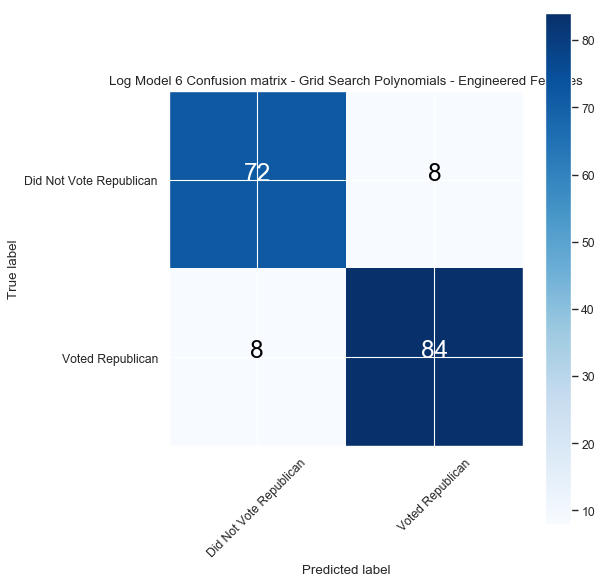

In [68]:
#View the confusion matrix
confusion_log_model_6 = metrics.confusion_matrix(y_test_log_model_6, y_pred_test_log_model_6)
plot_confusion_matrix(confusion_log_model_6, title='Log Model 6 Confusion matrix - Grid Search Polynomials - Engineered Features')

In [71]:
#Run this code to save the model data
#make_pickle(log_model_6, 'log_model_6')

## 11. KNN - Standard Set

In [72]:
#Splits the data for the KNN model gridsearch, using the standard features
X_train_KNN_model_1, X_test_KNN_model_1, y_train_KNN_model_1, y_test_KNN_model_1 =  reset_data()

sc_log_KNN_model_1=StandardScaler()
X_train_scaled_KNN_model_1= sc_log_KNN_model_1.fit_transform(X_train_KNN_model_1)
X_test_scaled_KNN_model_1 = sc_log_KNN_model_1.transform(X_test_KNN_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [73]:
#Creates a pipeline of parameters for the KNN model
pipe_KNN_poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
            ('scl', StandardScaler()),
            ('knn', KNeighborsClassifier())])

In [74]:
#Creates parameters for the KNN model
neighbors= list(range(1,20,2))
grid_params_KNN = [{'knn__n_neighbors':neighbors, 'knn__weights': ['uniform', 'distance']}] 

In [75]:
#Creates the KNN model
KNN_model_1 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5, verbose = 5)

In [76]:
#Fits the KNN model to the data
KNN_model_1.fit(X_train_KNN_model_1, y_train_KNN_model_1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8689655172413793, total=   2.7s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.7972972972972973, total=   2.7s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8413793103448276, total=   2.6s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8208955223880597, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.9s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.9014084507042254, total=   2.5s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8689655172413793, total=   2.6s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.7972972972972973, total=   2.6s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8413793103448276, total=   2.5s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8208955223880597, total=   2.5s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.9014084507042254, total=   2.6s
[CV] knn__n_neighbors=3, knn__weights=uniform ........................
[CV]  knn__n_neighbors=3, knn__weights=un

[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.8289473684210527, total=   2.8s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.9027777777777779, total=   2.9s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.8732394366197184, total=   2.8s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.9027777777777779, total=   2.8s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.8400000000000001, total=   2.9s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.8366013071895425, total=   2.8s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weig

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [77]:
# Best params
print('Best params: %s' % KNN_model_1.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_1.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_1 = KNN_model_1.predict(X_test_KNN_model_1)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Best params: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best training accuracy: 0.874
Test set F1 score for best params: 0.8602 


In [78]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_1 = KNN_model_1.predict(X_train_KNN_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("Training F1 Score for KNN Model 1 (Standard Features):", f1_score(y_train_KNN_model_1, y_pred_train_KNN_model_1))
print("")
print("Testing Accuracy for KNN Model 1 (Standard Features):", accuracy_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))
print("Testing F1 Score for KNN Model 1 (Standard Features):", f1_score(y_test_KNN_model_1, y_pred_test_KNN_model_1))

Training Accuracy for KNN Model 1 (Standard Features): 1.0
Training F1 Score for KNN Model 1 (Standard Features): 1.0

Testing Accuracy for KNN Model 1 (Standard Features): 0.8488372093023255
Testing F1 Score for KNN Model 1 (Standard Features): 0.8602150537634409


Confusion Matrix, without normalization


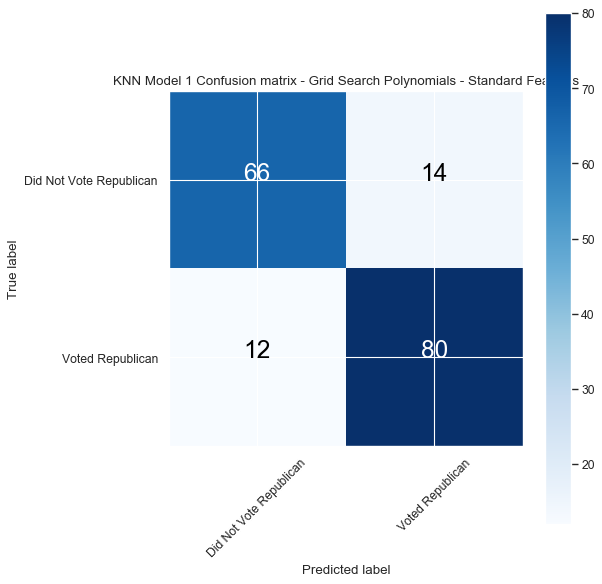

In [79]:
#Plots the confusion matrix
confusion_KNN_model_1 = metrics.confusion_matrix(y_test_KNN_model_1, y_pred_test_KNN_model_1)
plot_confusion_matrix(confusion_KNN_model_1, title='KNN Model 1 Confusion matrix - Grid Search Polynomials - Standard Features')

## 12. KNN - Engineered Features

In [80]:
#Splits the data for the KNN model gridsearch, using the engineered features
X_train_KNN_model_2, X_test_KNN_model_2, y_train_KNN_model_2, y_test_KNN_model_2 =  reset_data('engineered')

sc_log_KNN_model_2=StandardScaler()
X_train_scaled_KNN_model_2= sc_log_KNN_model_2.fit_transform(X_train_KNN_model_2)
X_test_scaled_KNN_model_2 = sc_log_KNN_model_2.transform(X_test_KNN_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [81]:
#Creates the KNN model
KNN_model_2 = GridSearchCV(estimator=pipe_KNN_poly, param_grid=grid_params_KNN, scoring='f1',
                           cv=5, verbose = 5)

In [82]:
#Fits the KNN model to the data
KNN_model_2.fit(X_train_KNN_model_2, y_train_KNN_model_2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8163265306122449, total=   2.6s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.802721088435374, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8085106382978723, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.8333333333333334, total=   2.2s
[CV] knn__n_neighbors=1, knn__weights=uniform ........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.5s remaining:    0.0s


[CV]  knn__n_neighbors=1, knn__weights=uniform, score=0.875, total=   2.1s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8163265306122449, total=   2.4s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.802721088435374, total=   2.2s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8085106382978723, total=   2.3s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.8333333333333334, total=   2.1s
[CV] knn__n_neighbors=1, knn__weights=distance .......................
[CV]  knn__n_neighbors=1, knn__weights=distance, score=0.875, total=   2.2s
[CV] knn__n_neighbors=3, knn__weights=uniform ........................
[CV]  knn__n_neighbors=3, knn__weights=uniform, score=0.853333333333

[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.830188679245283, total=   2.4s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.888888888888889, total=   2.4s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.9066666666666667, total=   2.9s
[CV] knn__n_neighbors=11, knn__weights=distance ......................
[CV]  knn__n_neighbors=11, knn__weights=distance, score=0.8531468531468531, total=   2.5s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.8571428571428571, total=   2.5s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, score=0.825, total=   2.6s
[CV] knn__n_neighbors=13, knn__weights=uniform .......................
[CV]  knn__n_neighbors=13, knn__weights=uniform, sc

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'knn__weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=5)

In [83]:
# Best params
print('Best params: %s' % KNN_model_2.best_params_)
# Best training data accuracy
print('Best training accuracy: %.3f' % KNN_model_2.best_score_)
# Predict on test data with best params
y_pred_test_KNN_model_2 = KNN_model_2.predict(X_test_KNN_model_2)
# Test data accuracy of model with best params
print('Test set F1 score for best params: %.4f ' % f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Best params: {'knn__n_neighbors': 13, 'knn__weights': 'distance'}
Best training accuracy: 0.870
Test set F1 score for best params: 0.8482 


In [84]:
# Make predictions for scoring purposes
y_pred_train_KNN_model_2 = KNN_model_2.predict(X_train_KNN_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("Training F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_train_KNN_model_2, y_pred_train_KNN_model_2))
print("")
print("Testing Accuracy for KNN Model 2 (Engineered Features):", accuracy_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))
print("Testing F1 Score for KNN Model 2 (Engineered Features):", f1_score(y_test_KNN_model_2, y_pred_test_KNN_model_2))

Training Accuracy for KNN Model 2 (Engineered Features): 1.0
Training F1 Score for KNN Model 2 (Engineered Features): 1.0

Testing Accuracy for KNN Model 2 (Engineered Features): 0.8313953488372093
Testing F1 Score for KNN Model 2 (Engineered Features): 0.8481675392670157


Confusion Matrix, without normalization


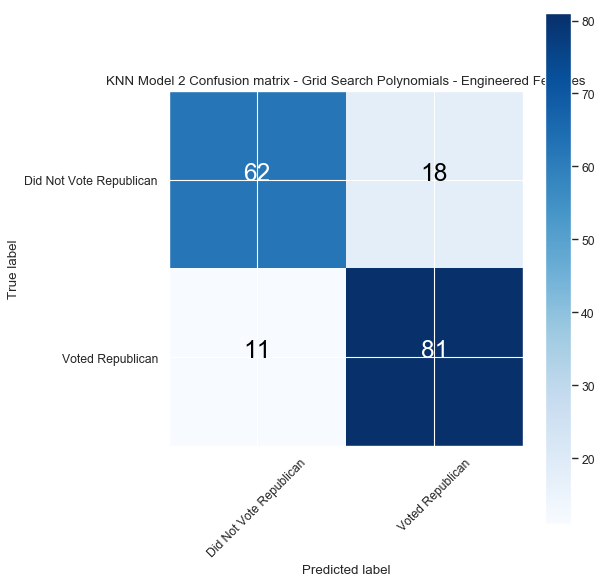

In [85]:
#Plots the confusin matrix
confusion_KNN_model_2 = metrics.confusion_matrix(y_test_KNN_model_2, y_pred_test_KNN_model_2)
plot_confusion_matrix(confusion_KNN_model_2, title='KNN Model 2 Confusion matrix - Grid Search Polynomials - Engineered Features')

## 13. A Function to Visualize Decision Trees

In [86]:
def plot_decision_tree(clf, feature_cols, class_titles, file_name):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names = class_titles)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    
    
    graph.write_png(file_name + '.png')
    
    return Image(graph.create_png())

## 14. Decision Trees - Standard Set

In [87]:
#Splits the data for the decision tree model using the standard features
X_train_DT_model_1, X_test_DT_model_1, y_train_DT_model_1, y_test_DT_model_1 =  reset_data()

In [88]:
# Create Decision Tree classifer object
DT_model_1 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_1 = DT_model_1.fit(X_train_DT_model_1, y_train_DT_model_1)

In [89]:
# Predict on training data with best params
y_pred_train_DT_model_1 = DT_model_1.predict(X_train_DT_model_1)

#Predict the response for test dataset
y_pred_test_DT_model_1 = DT_model_1.predict(X_test_DT_model_1)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("Training F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_train_DT_model_1, y_pred_train_DT_model_1))
print("")
print("Testing Accuracy for Decision Tree Model 1 (Standard Features):", accuracy_score(y_test_DT_model_1, y_pred_test_DT_model_1))
print("Testing F1 Score for Decision Tree Model 1 (Standard Features):", f1_score(y_test_DT_model_1, y_pred_test_DT_model_1))

Training Accuracy for Decision Tree Model 1 (Standard Features): 1.0
Training F1 Score for Decision Tree Model 1 (Standard Features): 1.0

Testing Accuracy for Decision Tree Model 1 (Standard Features): 0.8953488372093024
Testing F1 Score for Decision Tree Model 1 (Standard Features): 0.9010989010989011


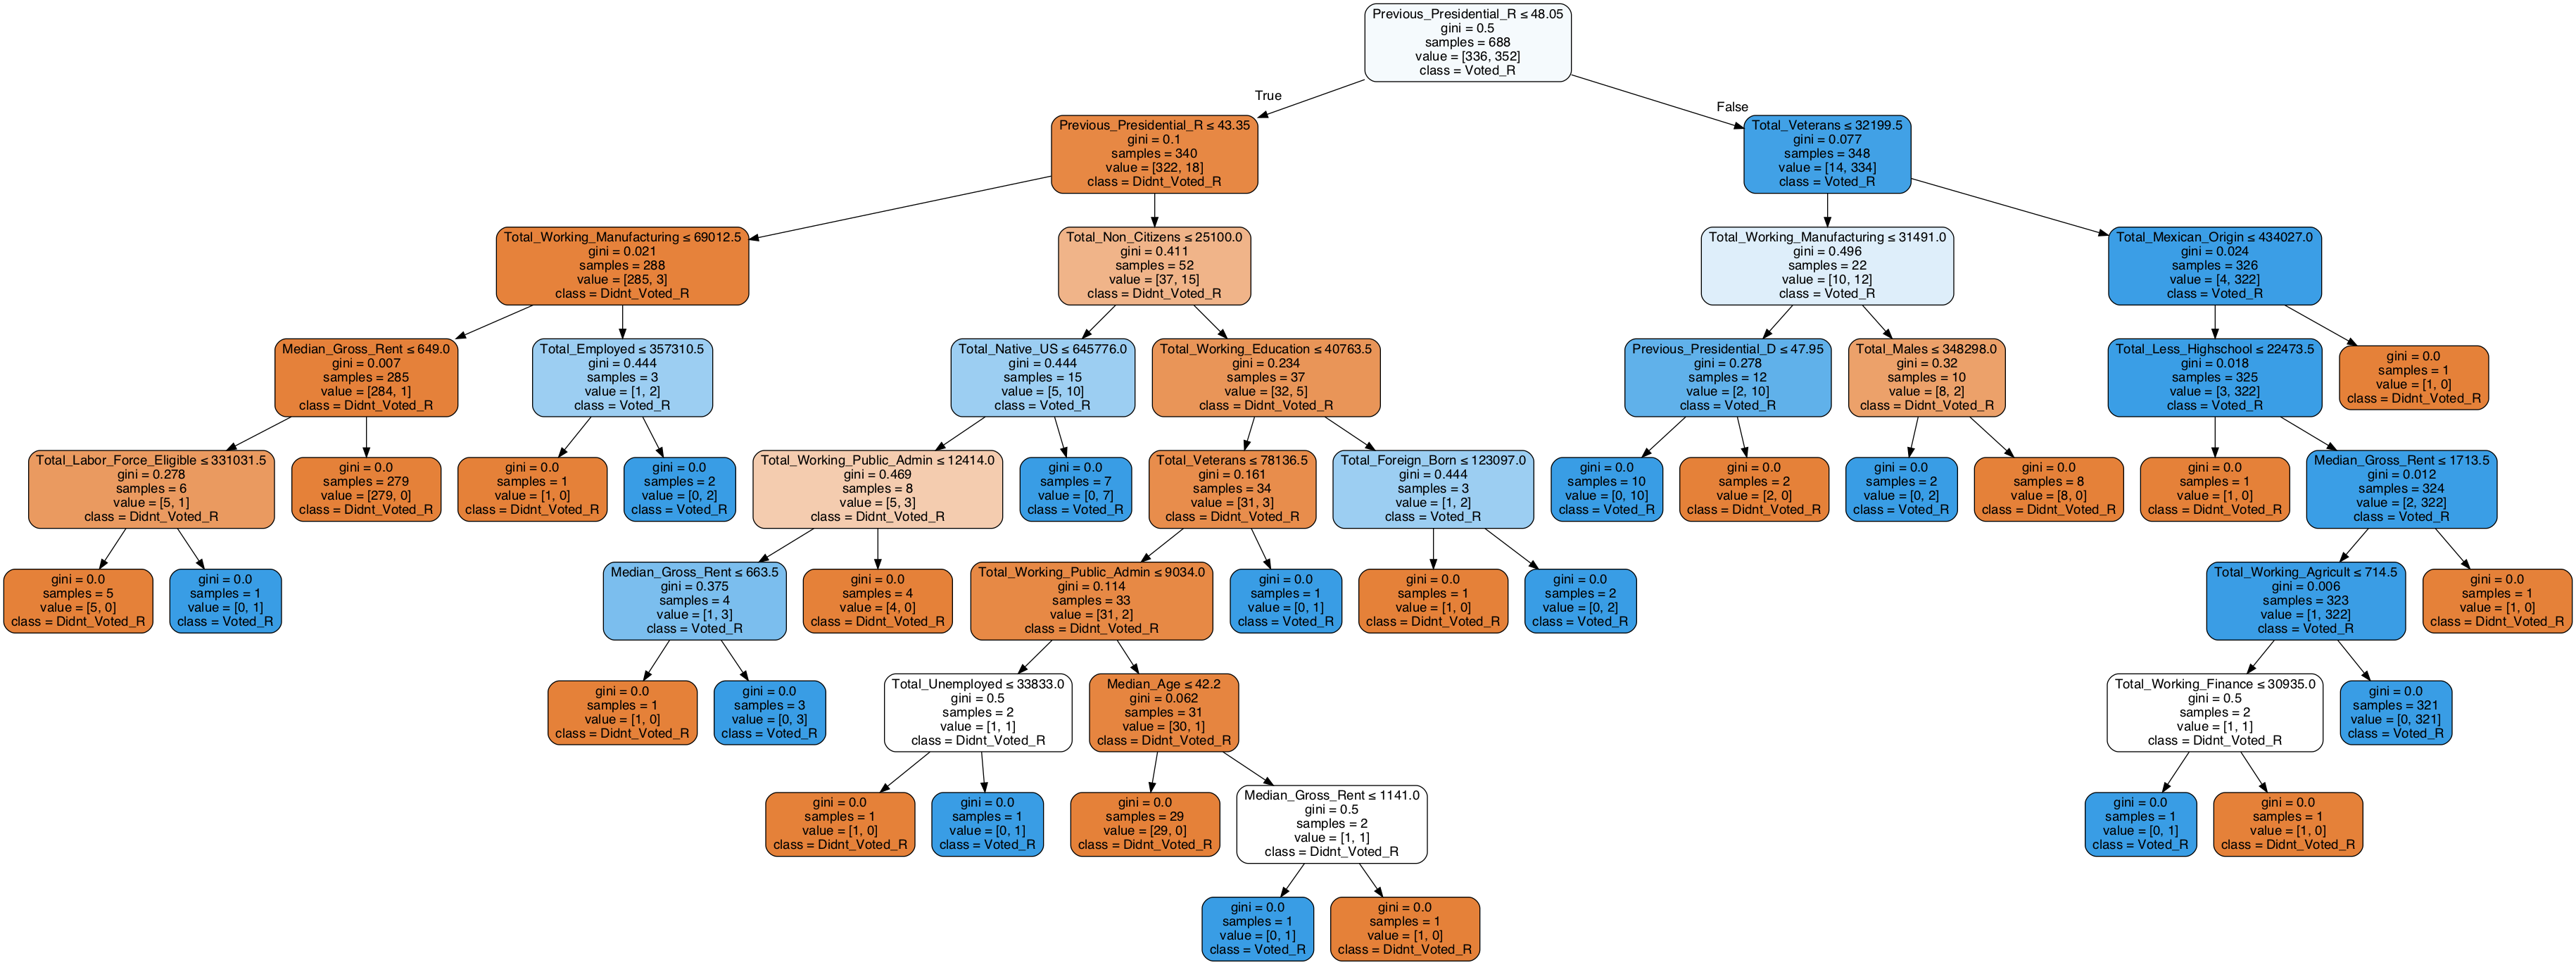

In [90]:
plot_decision_tree(DT_model_1, list(X_train_DT_model_1.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_1')

## 14. Decision Trees - Engineered Set


In [91]:
#Splits the data for the decision tree model using the engineered features
X_train_DT_model_2, X_test_DT_model_2, y_train_DT_model_2, y_test_DT_model_2 =  reset_data('engineered')

In [92]:
# Create Decision Tree classifer object
DT_model_2 = DecisionTreeClassifier()
# Train Decision Tree Classifer
DT_model_2 = DT_model_2.fit(X_train_DT_model_2, y_train_DT_model_2)

In [94]:
# Predict on training data with best params
y_pred_train_DT_model_2 = DT_model_2.predict(X_train_DT_model_2)

#Predict the response for test dataset
y_pred_test_DT_model_2 = DT_model_2.predict(X_test_DT_model_2)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("Training F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_train_DT_model_2, y_pred_train_DT_model_2))
print("")
print("Testing Accuracy for Decision Tree Model 2 (Engineered Features):", accuracy_score(y_test_DT_model_2, y_pred_test_DT_model_2))
print("Testing F1 Score for Decision Tree Model 2 (Engineered Features):", f1_score(y_test_DT_model_2, y_pred_test_DT_model_2))

Training Accuracy for Decision Tree Model 2 (Engineered Features): 1.0
Training F1 Score for Decision Tree Model 2 (Engineered Features): 1.0

Testing Accuracy for Decision Tree Model 2 (Engineered Features): 0.8604651162790697
Testing F1 Score for Decision Tree Model 2 (Engineered Features): 0.8695652173913043


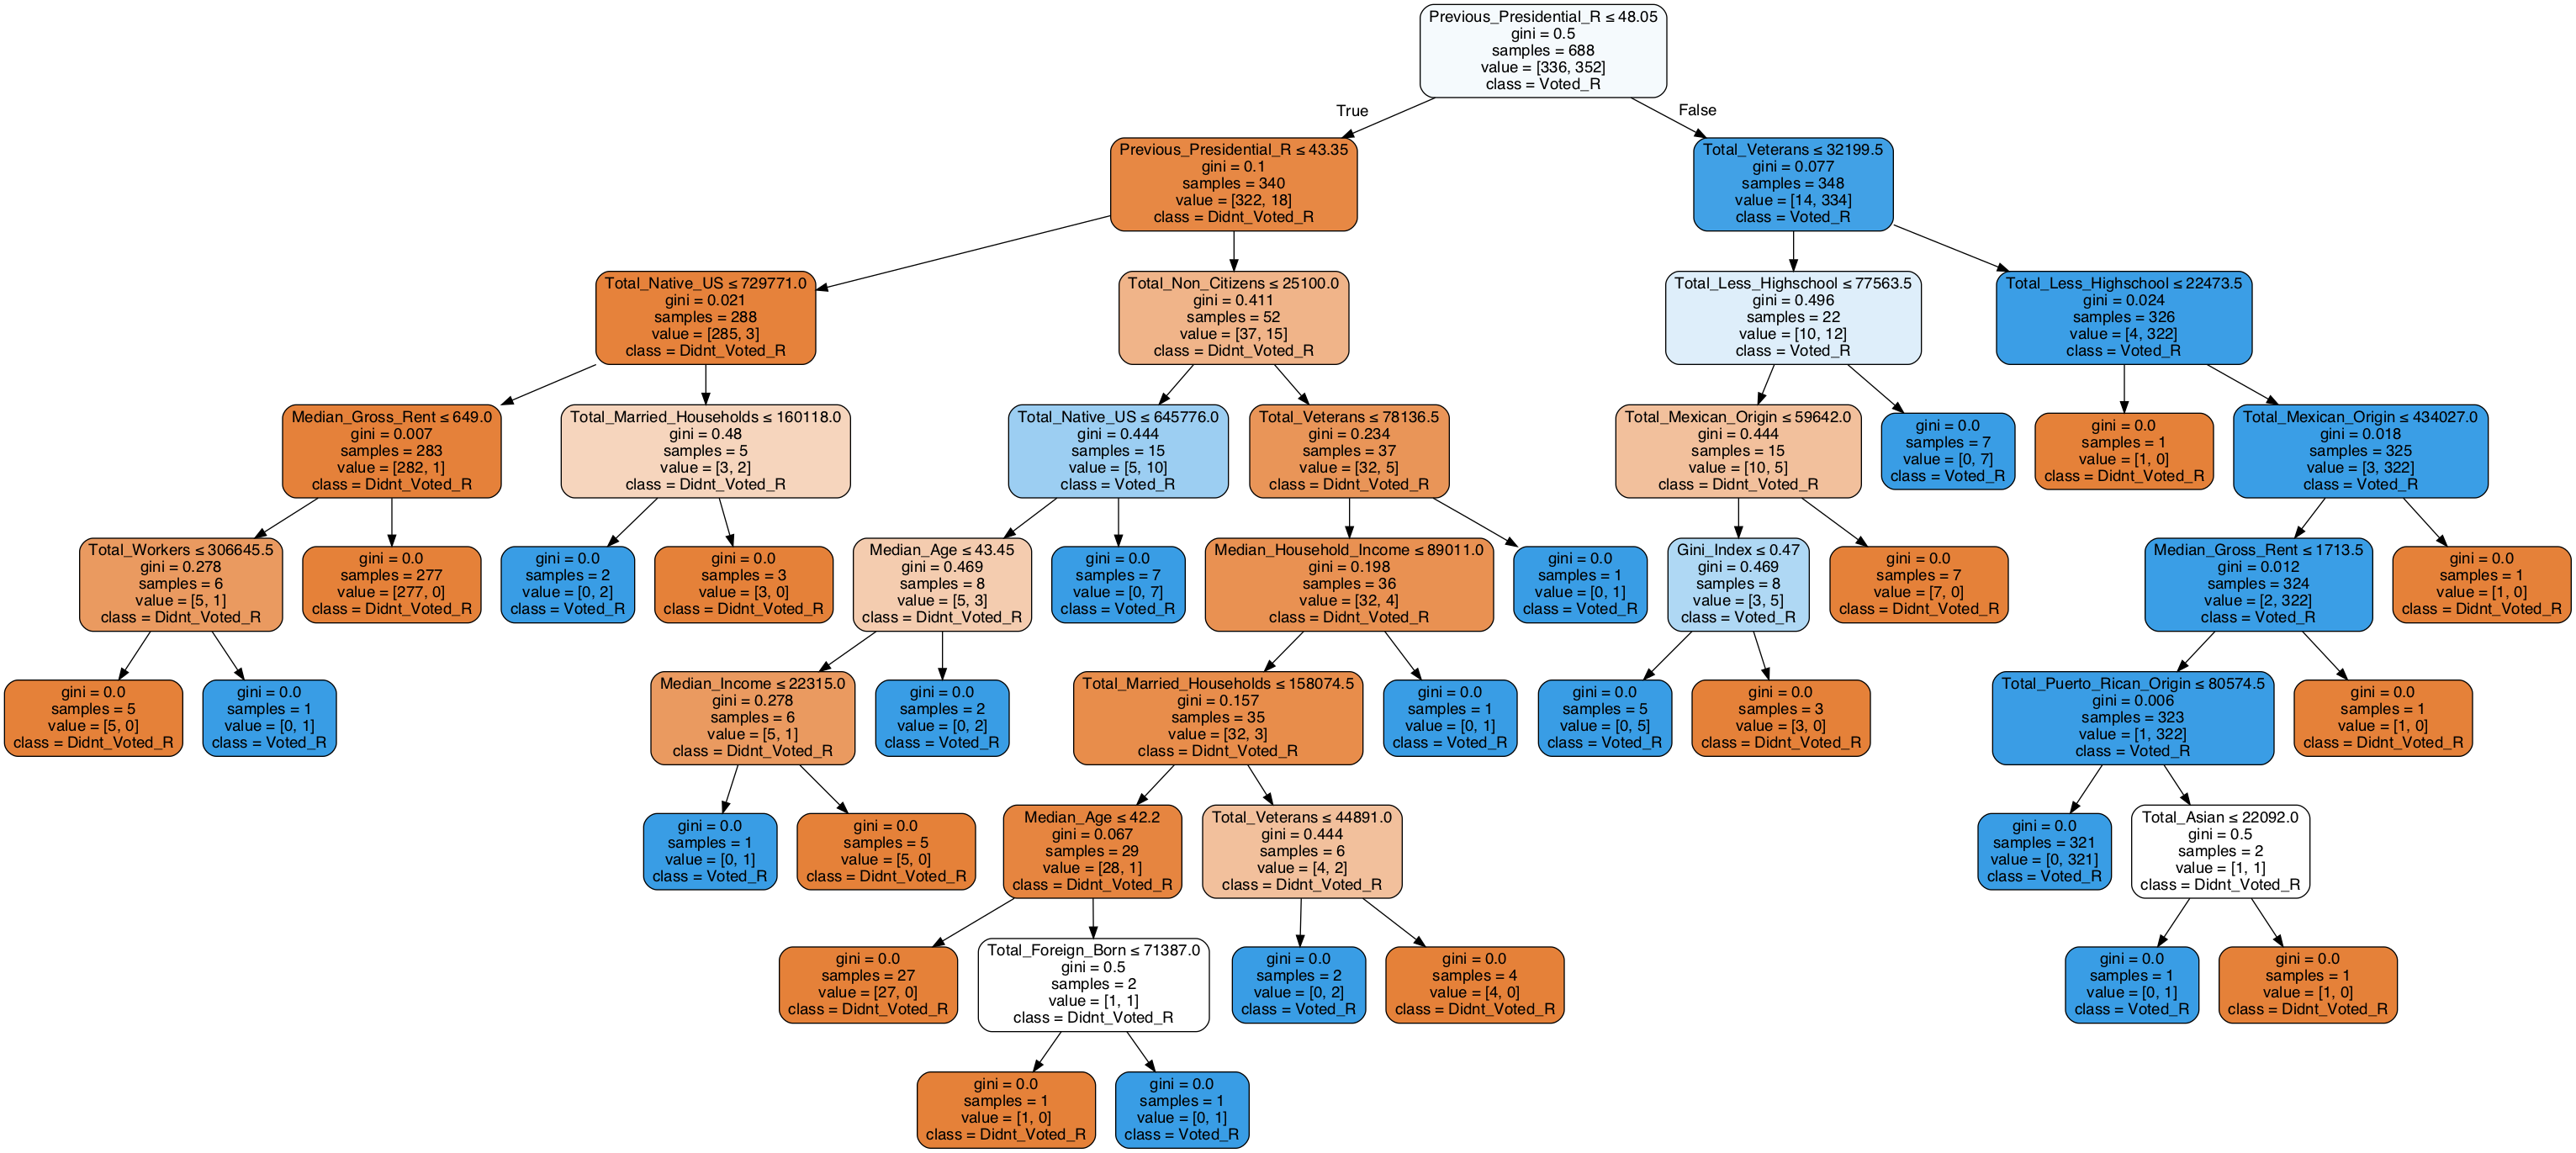

In [95]:
plot_decision_tree(DT_model_2, list(X_train_DT_model_2.columns), ['Didnt_Voted_R', 'Voted_R'], 'DT_model_2')

## 15. Decision Trees - Grid Search - Standard Set

In [96]:
#Splits the data for the decision tree model gridsearch, using the standard features
X_train_DT_model_3, X_test_DT_model_3, y_train_DT_model_3, y_test_DT_model_3 =  reset_data()

In [97]:
# The scorers used in the gridsearch to find the best parameters
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [98]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_3 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True, verbose = 5)


In [99]:
DT_model_3.fit(X_train_DT_model_3, y_train_DT_model_3)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9653065451532725, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9793987807441665, Accuracy=0.9347826086956522, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9979744136460554, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9432835820895522, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9740938166311301, Accuracy=0.927

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9907504729871769, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9681236673773987, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9805970149253731, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.9705756929637528, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=3, min_samples_leaf=95, AUC=0.9852878464818763, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth

[CV]  criterion=gini, max_depth=5, min_samples_leaf=20, AUC=0.9654584221748401, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=20, AUC=0.9972281449893391, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=35, AUC=0.9569179784589892, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=35, AUC=0.9823418120664285, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=35, AUC=0.9966950959488273, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=35 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.9886483077569896, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.9932835820895523, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.9782515991471216, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=65, AUC=0.9906183368869936, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_depth=6, min_samples_leaf=80, AUC=0.9751449875724938, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=80 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.9690347970173985, Accuracy=0.9424460431654677, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.9694134959007779, Accuracy=0.927536231884058, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.9767590618336887, Accuracy=0.9343065693430657, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.9413646055437102, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=5, AUC=0.9621535181236675, Accuracy=0.9051094890510949, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=8, mi

[CV]  criterion=gini, max_depth=9, min_samples_leaf=35, AUC=0.9966950959488273, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=35, AUC=0.9752665245202559, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=35 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=35, AUC=0.9933901918976545, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=50, AUC=0.9621996685998343, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=50 ................
[CV]  criterion=gini, max_dept

[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, AUC=0.9763326226012793, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=80, AUC=0.9893390191897655, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=10, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_

[CV]  criterion=gini, max_depth=12, min_samples_leaf=5, AUC=0.9621535181236675, Accuracy=0.9051094890510949, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.9589892294946147, Accuracy=0.8848920863309353, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.9841286525120874, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.9977611940298508, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=20, AUC=0.9654584221748401, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_

[CV]  criterion=gini, max_depth=13, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=50, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=50, AUC=0.9667377398720683, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=50, AUC=0.9901918976545843, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=13, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=13, min_samples_leaf=65 ...............
[CV]  criterion=gini, max

[CV]  criterion=gini, max_depth=14, min_samples_leaf=80, AUC=0.9763326226012793, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=80, AUC=0.9893390191897655, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_

[CV]  criterion=gini, max_depth=16, min_samples_leaf=20, AUC=0.9589892294946147, Accuracy=0.8848920863309353, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=16, min_samples_leaf=20, AUC=0.9841286525120874, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=16, min_samples_leaf=20, AUC=0.9977611940298508, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=16, min_samples_leaf=20, AUC=0.9654584221748401, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=16, min_samples_leaf=20, AUC=0.9972281449893391, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=16, min_samples_leaf=35 ...............
[CV]  criterion=gini, max

[CV]  criterion=gini, max_depth=17, min_samples_leaf=50, AUC=0.9667377398720683, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=50, AUC=0.9901918976545843, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=65, AUC=0.9886483077569896, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=65, AUC=0.9932835820895523, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=65 ...............
[CV]  criterion=gini, max

[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, AUC=0.9705756929637528, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=95, AUC=0.9852878464818763, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=19, min_samples_leaf=5, AUC=0.9690347970173985, Accuracy=0.9424460431654677, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=19, min_samples_leaf=5, AUC=0.9694134959007779, Accuracy=0.927536231884058, total=   0.0s
[CV] criterion=gini, max_depth=19, min_samples_leaf=5 ................
[CV]  criterion=gini, max_de

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.9805970149253731, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.9569179784589892, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.9907504729871769, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=35, AUC=0.970042643923241, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, AUC=0.9667377398720683, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, AUC=0.9901918976545843, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.987807441664915, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, AUC=0.9763326226012793, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=80, AUC=0.9857142857142858, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=5, AUC=0.9142502071251036, Accuracy=0.8992805755395683, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=5, AUC=0.9675215471936095, Accuracy=0.9492753623188406, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=5, AUC=0.952771855010661, Accuracy=0.9197080291970803, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=5, AUC=0.9252665245202558, Accuracy=0.8978102189781022, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=5, AUC=0.96044776119403, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=20 .............
[CV]  criterion=entropy,

[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.987807441664915, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9782515991471216, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9906183368869936, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=80 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=8, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=80, AUC=0.9763326226012793, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=80, AUC=0.9857142857142858, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=8, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=8, min_samples_leaf=95 .............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, AUC=0.9142502071251036, Accuracy=0.8992805755395683, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, AUC=0.9675215471936095, Accuracy=0.9492753623188406, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, AUC=0.952771855010661, Accuracy=0.9197080291970803, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, AUC=0.9252665245202558, Accuracy=0.8978102189781022, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=5, AUC=0.96044776119403, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=20 ............
[CV]  criterion=ent

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.996908315565032, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.9765458422174841, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=20, AUC=0.9883795309168444, Accuracy=0.9343065693430657, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, AUC=0.9569179784589892, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=35, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=35 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=12, min_samples_leaf=35, AUC=0.9788912579957356, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=50, AUC=0.9621996685998343, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=50, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=12, min_samples_leaf=50, AUC=0.9667377398720683, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_leaf=50 ............
[CV]  crit

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, AUC=0.9782515991471216, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=65, AUC=0.9906183368869936, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=80, AUC=0.9751449875724938, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=80 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, AUC=0.9705756929637528, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=95, AUC=0.9852878464818763, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=5, AUC=0.9142502071251036, Accuracy=0.8992805755395683, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=5 .............
[CV]  criter

[CV]  criterion=entropy, max_depth=16, min_samples_leaf=5, AUC=0.96044776119403, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=20, AUC=0.9589892294946147, Accuracy=0.8848920863309353, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=20, AUC=0.9909606895101956, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=20, AUC=0.996908315565032, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=16, min_samples_leaf=20, AUC=0.9765458422174841, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=16, min_samples_leaf=20 ............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.9750533049040512, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=35, AUC=0.9788912579957356, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=50, AUC=0.9621996685998343, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=50 ............
[CV]  crit

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.9737986743993372, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.987807441664915, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.9782515991471216, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=65, AUC=0.9906183368869936, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=80 ............
[CV]  crite

[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.9715202982601492, Accuracy=0.9280575539568345, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.9705756929637528, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=95, AUC=0.9852878464818763, Accuracy=0.9708029197080292, total=   0.0s


[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:   17.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=5)

In [100]:
# Predict on training data with best params
y_pred_train_DT_model_3 = DT_model_3.predict(X_train_DT_model_3)

#Predict the response for test dataset
y_pred_test_DT_model_3 = DT_model_3.predict(X_test_DT_model_3)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("Training F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_train_DT_model_3, y_pred_train_DT_model_3))
print("")
print("Testing Accuracy for Decision Tree Model 3 GS (Standard Features):", accuracy_score(y_test_DT_model_3, y_pred_test_DT_model_3))
print("Testing F1 Score for Decision Tree Model 3 GS (Standard Features):", f1_score(y_test_DT_model_3, y_pred_test_DT_model_3))

Training Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9534883720930233
Training F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9542857142857143

Testing Accuracy for Decision Tree Model 3 GS (Standard Features): 0.9186046511627907
Testing F1 Score for Decision Tree Model 3 GS (Standard Features): 0.9222222222222224


In [101]:
print('The top score for a decision tree is: ' + str(DT_model_3.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_3.best_params_))
print('The top performing decision tree is: ')
print(DT_model_3.best_estimator_)

The top score for a decision tree is: 0.9848931892367947
The parameters for the top performing decision tree is: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 65}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=65, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [102]:
DT_model_3.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_train_Accuracy', 'split1_train_Accuracy', 'split2_train_Accuracy', 'split3_train_Accuracy', 'split4_train_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy'])

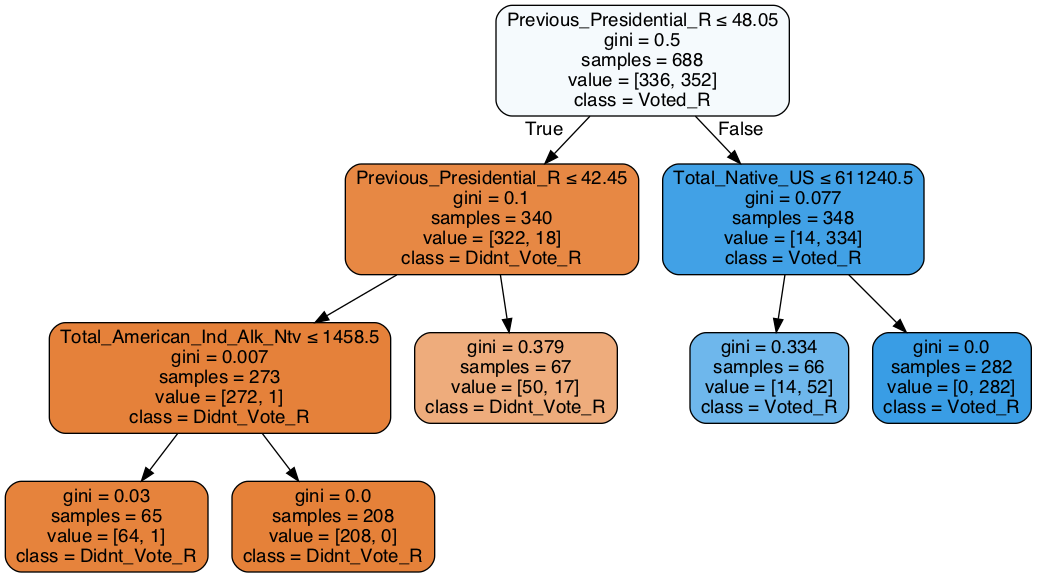

In [103]:
plot_decision_tree(DT_model_3.best_estimator_, list(X_train_DT_model_3.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_3')

## 16. Decision Trees - Grid Search - Engineered Set

In [104]:
#Splits the data for the decision tree model gridsearch, using the engineered features
X_train_DT_model_4, X_test_DT_model_4, y_train_DT_model_4, y_test_DT_model_4 =  reset_data('engineered')

In [105]:
#Parameters and model creation
parameters ={'criterion': ['gini','entropy'], 'min_samples_leaf' : range(5,100,15), 'max_depth': range(2,20,1)}

DT_model_4 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid= parameters,
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True, verbose = 5)

In [106]:
DT_model_4.fit(X_train_DT_model_4, y_train_DT_model_4)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9660314830157415, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9793987807441665, Accuracy=0.9347826086956522, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9979744136460554, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9603411513859275, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=5, AUC=0.9829424307036247, Accuracy=0.9562

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9673773987206824, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=50, AUC=0.9805970149253731, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=65, AUC=0.9743164871582435, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=2, min_samples_leaf=65, AUC=0.9886483077569896, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth

[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.9533319318898467, Accuracy=0.927536231884058, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.9833688699360341, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.9554371002132198, Accuracy=0.9416058394160584, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, AUC=0.9883795309168444, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, min_samples_leaf=20, AUC=0.9676884838442419, Accuracy=0.8920863309352518, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=4, mi

[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.9663113006396589, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=50, AUC=0.9788912579957355, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.9743164871582435, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.9886483077569896, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth=5, min_samples_leaf=65, AUC=0.9932835820895523, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=65 ................
[CV]  criterion=gini, max_depth

[CV]  criterion=gini, max_depth=7, min_samples_leaf=5, AUC=0.9496531427370192, Accuracy=0.9347826086956522, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=5, AUC=0.9986140724946695, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=5, AUC=0.9460554371002132, Accuracy=0.9416058394160584, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=5 .................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=5, AUC=0.9697228144989339, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=7, min_samples_leaf=20, AUC=0.9676884838442419, Accuracy=0.8920863309352518, total=   0.0s
[CV] criterion=gini, max_depth=7, min_samples_leaf=20 ................
[CV]  criterion=gini, max_depth=7, m

[CV]  criterion=gini, max_depth=8, min_samples_leaf=35, AUC=0.9791044776119403, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=50, AUC=0.9632352941176471, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=50, AUC=0.994456289978678, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=8, min_samples_leaf=50, AUC=0.9663113006396589, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=8, min_samples_leaf=50 ................
[CV]  criterion=gini, max_depth=

[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.981290729451335, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.9552238805970148, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=95 ................
[CV]  criterion=gini, max_depth=9, min_samples_leaf=95, AUC=0.9850746268656716, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth=10, min_samples_leaf=5, AUC=0.9647887323943662, Accuracy=0.9424460431654677, total=   0.0s
[CV] criterion=gini, max_depth=10, min_samples_leaf=5 ................
[CV]  criterion=gini, max_depth

[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, AUC=0.9812907294513349, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, AUC=0.9966950959488273, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, AUC=0.9684434968017057, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=35, AUC=0.9791044776119403, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_depth=11, min_samples_leaf=50, AUC=0.9632352941176471, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=50 ...............
[CV]  criterion=gini, max_

[CV]  criterion=gini, max_depth=12, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=80, AUC=0.9588486140724947, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=80, AUC=0.9827292110874201, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_depth=12, min_samples_leaf=95, AUC=0.968102734051367, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=12, min_samples_leaf=95 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, AUC=0.9977611940298508, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, AUC=0.964179104477612, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=20, AUC=0.9972281449893391, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=35, AUC=0.957953603976802, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=14, min_samples_leaf=35, AUC=0.9812907294513349, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=14, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=15, min_samples_leaf=65, AUC=0.9904051172707888, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=80, AUC=0.9626139188069593, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=15, min_samples_leaf=80, AUC=0.9588486140724947, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=15, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_d

[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, AUC=0.984023544250578, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, AUC=0.9977611940298508, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, AUC=0.964179104477612, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=20 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=20, AUC=0.9972281449893391, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_depth=17, min_samples_leaf=35, AUC=0.957953603976802, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=35 ...............
[CV]  criterion=gini, max_dep

[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.9932835820895523, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.9697228144989338, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=65 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=65, AUC=0.9904051172707888, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=80, AUC=0.9626139188069593, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_depth=18, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_leaf=80 ...............
[CV]  criterion=gini, max_d

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.957953603976802, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.9839184359890688, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.9695095948827293, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=20 .............
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=20, AUC=0.9805970149253731, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=35 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, AUC=0.9663113006396589, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=50 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=50, AUC=0.9788912579957355, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.9743164871582435, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.987807441664915, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=65 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=95, AUC=0.9930703624733475, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=95, AUC=0.9552238805970148, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=95 .............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=95, AUC=0.9850746268656716, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, AUC=0.9554681027340514, Accuracy=0.8992805755395683, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=5, AUC=0.9616354845490857, Accuracy=0.9492753623188406, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=5 ..............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=20, AUC=0.9754797441364607, Accuracy=0.9343065693430657, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, AUC=0.957953603976802, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=35, AUC=0.9684434968017057, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=35 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9929637526652453, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9697228144989338, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=65 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=65, AUC=0.9904051172707888, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=80, AUC=0.9626139188069593, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=80 .............
[CV]  criterion=entropy, max_depth=7, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=7, min_samples_leaf=80 .............
[CV]  criterion=e

[CV]  criterion=entropy, max_depth=9, min_samples_leaf=5, AUC=0.9554681027340514, Accuracy=0.8992805755395683, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=5, AUC=0.9550136640739962, Accuracy=0.9420289855072463, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=5, AUC=0.9808102345415778, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=5, AUC=0.9440298507462688, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=9, min_samples_leaf=5, AUC=0.9619402985074628, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_leaf=20 .............
[CV]  criterion=entrop

[CV]  criterion=entropy, max_depth=10, min_samples_leaf=35, AUC=0.957953603976802, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=35, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=35, AUC=0.9944562899786781, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=35, AUC=0.9684434968017057, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=10, min_samples_leaf=35, AUC=0.979317697228145, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=10, min_samples_leaf=50 ............
[CV]  criteri

[CV]  criterion=entropy, max_depth=11, min_samples_leaf=65, AUC=0.9697228144989338, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=65 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=65, AUC=0.9904051172707888, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=80, AUC=0.9626139188069593, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=80 ............
[CV]  criter

[CV]  criterion=entropy, max_depth=13, min_samples_leaf=5, AUC=0.9550136640739962, Accuracy=0.9420289855072463, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=5, AUC=0.9808102345415778, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=5, AUC=0.9440298507462688, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=5, AUC=0.9619402985074628, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=13, min_samples_leaf=20, AUC=0.9604391052195527, Accuracy=0.8920863309352518, total=   0.0s
[CV] criterion=entropy, max_depth=13, min_samples_leaf=20 ............
[CV]  criterion=

[CV]  criterion=entropy, max_depth=14, min_samples_leaf=35, AUC=0.9684434968017057, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=35 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=35, AUC=0.979317697228145, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=50, AUC=0.9632352941176471, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=14, min_samples_leaf=50, AUC=0.994456289978678, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=14, min_samples_leaf=50 ............
[CV]  criteri

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=80, AUC=0.9588486140724947, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=80, AUC=0.985501066098081, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=95 ............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=95, AUC=0.968102734051367, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=95 ............
[CV]  criterio

[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, AUC=0.9440298507462688, Accuracy=0.927007299270073, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=5 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=5, AUC=0.9619402985074628, Accuracy=0.9562043795620438, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.9604391052195527, Accuracy=0.8920863309352518, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.9908555812486862, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=20, AUC=0.9969083155650319, Accuracy=0.948905109489051, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=20 ............
[CV]  criterio

[CV]  criterion=entropy, max_depth=18, min_samples_leaf=35, AUC=0.979317697228145, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.9632352941176471, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.9907504729871768, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.994456289978678, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criterion=entropy, max_depth=18, min_samples_leaf=50, AUC=0.9663113006396589, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=18, min_samples_leaf=50 ............
[CV]  criteri

[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.9626139188069593, Accuracy=0.935251798561151, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.983392894681522, Accuracy=0.9565217391304348, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.9916844349680172, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.9588486140724947, Accuracy=0.9124087591240876, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=80 ............
[CV]  criterion=entropy, max_depth=19, min_samples_leaf=80, AUC=0.985501066098081, Accuracy=0.9708029197080292, total=   0.0s
[CV] criterion=entropy, max_depth=19, min_samples_leaf=95 ............
[CV]  criteri

[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:   16.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(5, 100, 15), 'max_depth': range(2, 20)},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score=True,
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=5)

In [107]:
# Predict on training data with best params
y_pred_train_DT_model_4 = DT_model_4.predict(X_train_DT_model_4)

#Predict the response for test dataset
y_pred_test_DT_model_4 = DT_model_4.predict(X_test_DT_model_4)

# Prints the accuracy and f1 scores
print("Training Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("Training F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_train_DT_model_4, y_pred_train_DT_model_4))
print("")
print("Testing Accuracy for Decision Tree Model 4 GS (Engineered Features):", accuracy_score(y_test_DT_model_4, y_pred_test_DT_model_4))
print("Testing F1 Score for Decision Tree Model 4 GS (Engineered Features):", f1_score(y_test_DT_model_4, y_pred_test_DT_model_4))

Training Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9534883720930233
Training F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9542857142857143

Testing Accuracy for Decision Tree Model 4 GS (Engineered Features): 0.9186046511627907
Testing F1 Score for Decision Tree Model 4 GS (Engineered Features): 0.9222222222222224


In [108]:
print('The top score for a decision tree is: ' + str(DT_model_4.best_score_))
print('The parameters for the top performing decision tree is: ' + str(DT_model_4.best_params_))
print('The top performing decision tree is: ')
print(DT_model_4.best_estimator_)

The top score for a decision tree is: 0.9832570284653798
The parameters for the top performing decision tree is: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 65}
The top performing decision tree is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=65, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


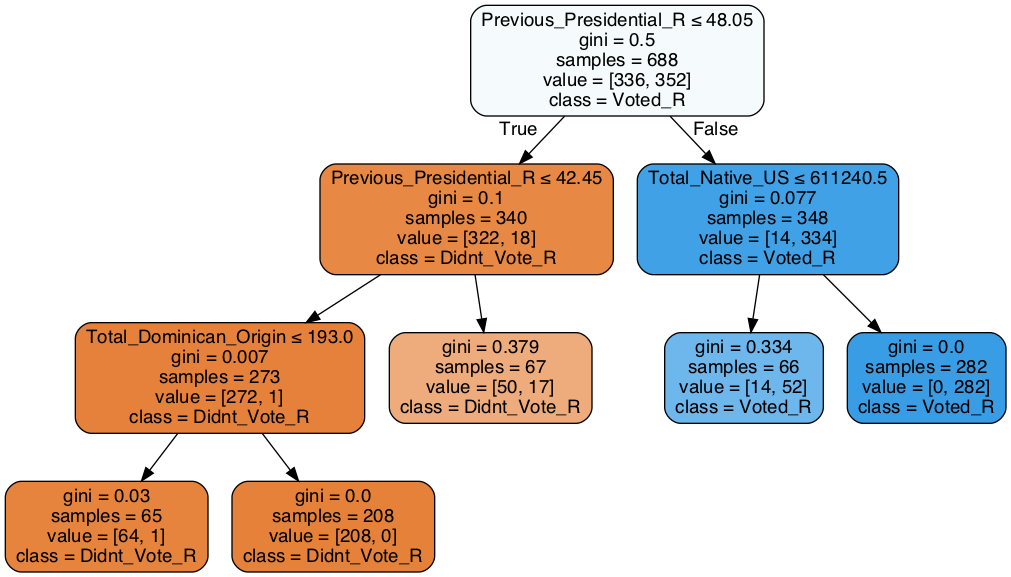

In [109]:
plot_decision_tree(DT_model_4.best_estimator_, list(X_train_DT_model_4.columns), ['Didnt_Vote_R', 'Voted_R'], 'DT_model_4')

## 17. Random Forest - Standard Set

In [110]:
#Creates the parameters for the random forest model
param_grid = { 
    'n_estimators': [200,300,400],
    'max_features': [0.25, 0.33, 0.5 ],
    'max_depth' : [5,6,7,8,9],
    'min_samples_leaf': [0.03,0.04,0.05,0.06]
}

In [111]:
#Splits the data for the random forest model using the standard features
X_train_rfc_model_1, X_test_rfc_model_1, y_train_rfc_model_1, y_test_rfc_model_1 =  reset_data()

In [112]:
#Fits the rf model
rfc_model_1 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1, verbose = 5)
rfc_model_1.fit(X_train_rfc_model_1, y_train_rfc_model_1)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [113]:
#Loading the saved random forest model with pickle
#rfc_model_1_pkl = open('./Classification_Models_After_rfc_model_1.pkl', 'rb')
#rfc_model_1 = pickle.load(rfc_model_1_pkl)
#print("Loaded rfc_model_1 Pickle :: ", rfc_model_1)
#print(rfc_model_1.best_estimator_.get_params())

In [114]:
# Predict on training data with best params
pred_rfc_model_1_train = rfc_model_1.predict(X_train_rfc_model_1)
#Predict the response for test dataset
pred_rfc_model_1 = rfc_model_1.predict(X_test_rfc_model_1)

In [115]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("Training F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_train_rfc_model_1, pred_rfc_model_1_train))
print("")
print("Testing Accuracy for Random Forest Model 1 (Standard Features):", accuracy_score(y_test_rfc_model_1, pred_rfc_model_1))
print("Testing F1 Score for Random Forest Model 1 (Standard Features):", f1_score(y_test_rfc_model_1, pred_rfc_model_1))

Training Accuracy for Random Forest Model 1 (Standard Features): 0.9578488372093024
Training F1 Score for Random Forest Model 1 (Standard Features): 0.9586305278174038

Testing Accuracy for Random Forest Model 1 (Standard Features): 0.9302325581395349
Testing F1 Score for Random Forest Model 1 (Standard Features): 0.934065934065934


In [116]:
print('The top score for a random forest is: ' + str(rfc_model_1.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_1.best_params_))
print('The top performing random forest is: ')
print(rfc_model_1.best_estimator_)

The top score for a random forest is: 0.9534883720930233
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.04, 'n_estimators': 200}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [118]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_1, 'rfc_model_1')

## 18. Random Forest - Engineered Set

In [119]:
#Splits the data for the random forest model using the engineered features
X_train_rfc_model_2, X_test_rfc_model_2, y_train_rfc_model_2, y_test_rfc_model_2 =  reset_data('engineered')

In [120]:
#Fits the rf model
rfc_model_2 = GridSearchCV(estimator= RandomForestClassifier(random_state = 23), param_grid=param_grid, cv= 5, n_jobs=-1, verbose = 5)
rfc_model_2.fit(X_train_rfc_model_2, y_train_rfc_model_2)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400], 'max_features': [0.25, 0.33, 0.5], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_leaf': [0.03, 0.04, 0.05, 0.06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [121]:
#Loading the saved random forest smote model with pickle
#rfc_model_2_pkl = open('./Classification_Models_After_rfc_model_2.pkl', 'rb')
#rfc_model_2 = pickle.load(rfc_model_2_pkl)
#print("Loaded rfc_model_2 Pickle :: ", rfc_model_2)
#print(rfc_model_2.best_estimator_.get_params())

In [122]:
# Predict on training data with best params
pred_rfc_model_2_train = rfc_model_2.predict(X_train_rfc_model_2)
#Predict the response for test dataset
pred_rfc_model_2 = rfc_model_2.predict(X_test_rfc_model_2)

In [123]:
# Prints the accuracy and f1 scores
print("Training Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("Training F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_train_rfc_model_2, pred_rfc_model_2_train))
print("")
print("Testing Accuracy for Random Forest Model 2 (Engineered Features):", accuracy_score(y_test_rfc_model_2, pred_rfc_model_2))
print("Testing F1 Score for Random Forest Model 2 (Engineered Features):", f1_score(y_test_rfc_model_2, pred_rfc_model_2))

Training Accuracy for Random Forest Model 2 (Engineered Features): 0.9578488372093024
Training F1 Score for Random Forest Model 2 (Engineered Features): 0.9586305278174038

Testing Accuracy for Random Forest Model 2 (Engineered Features): 0.9302325581395349
Testing F1 Score for Random Forest Model 2 (Engineered Features): 0.934065934065934


In [124]:
print('The top score for a random forest is: ' + str(rfc_model_2.best_score_))
print('The parameters for the top performing random forest is: ' + str(rfc_model_2.best_params_))
print('The top performing random forest is: ')
print(rfc_model_2.best_estimator_)

The top score for a random forest is: 0.9534883720930233
The parameters for the top performing random forest is: {'max_depth': 5, 'max_features': 0.25, 'min_samples_leaf': 0.04, 'n_estimators': 200}
The top performing random forest is: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.25, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.04, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)


In [126]:
#Run this code to save the random forest model data
#make_pickle(rfc_model_2, 'rfc_model_2')

## 19. XGBoost - Standard Set

In [127]:
#Make a df copy specifically for XGBoost

election_df_xgb = election_df.copy()

#Makes a features for later reference
features_list_xgb_model_1 = ['Total_Pop', 'Total_Males',
                         'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin',
                         'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens',
                         'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income',
                         'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index',
                         'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM',
                         'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
                         'Total_Working_Construction', 'Total_Working_Manufacturing',
                         'Total_Working_Retail', 'Total_Working_Transportation',
                         'Total_Working_Information', 'Total_Working_Finance', 
                         'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
                         'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D',
                         'Previous_Presidential_R']

#Separates the two dataframes
X_xgb_model_1 = election_df_xgb[features_list_xgb_model_1]
y_xgb_model_1 = election_df_xgb['Target_Presidential_R_bool']


In [128]:
#Scales the features and then splits them
scaler_xgb_model_1 = StandardScaler()
scaled_df_xgb_model_1 = scaler_xgb_model_1.fit_transform(X_xgb_model_1)

X_train_xgb_model_1, X_test_xgb_model_1, y_train_xgb_model_1, y_test_xgb_model_1 = train_test_split(scaled_df_xgb_model_1, y_xgb_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [129]:
#fits and then scores the XGBoost model
xgb_model_1 = xgb.XGBClassifier()
xgb_model_1.fit(X_train_xgb_model_1, y_train_xgb_model_1)
training_preds_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("Training Accuracy for the standard model: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation Accuracy for the standard model: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Training Accuracy for the standard model: 100.0%
Validation Accuracy for the standard model: 93.49%


In [130]:
#Creates a parameter grid for the gridsearch of XGBoost
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [131]:
#Creates an XGBoost model
xgb_model_1 = xgb.XGBClassifier()

In [132]:
#Fits the data to the model
xgb_model_1 = GridSearchCV(xgb_model_1, param_grid, scoring='accuracy', cv=None, n_jobs=1, verbose = 5)
xgb_model_1.fit(scaled_df_xgb_model_1, y_xgb_model_1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.9128919860627178, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.9477351916376306, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.965034965034965, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7, score=0.9128919860627178, total=   0.1s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_est

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s finished


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [133]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_1 = xgb_model_1.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_1.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_1[param_name]))

training_preds_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
val_preds_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)
training_accuracy_xgb_model_1 = accuracy_score(y_train_xgb_model_1, training_preds_xgb_model_1)
val_accuracy_xgb_model_1 = accuracy_score(y_test_xgb_model_1, val_preds_xgb_model_1)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_1 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_1 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 100
subsample: 0.7

Training Accuracy: 96.59%
Validation accuracy: 96.74%


In [134]:
#Makes predictions for model scoring
y_pred_train_xgb_model_1 = xgb_model_1.predict(X_train_xgb_model_1)
y_pred_test_xgb_model_1 = xgb_model_1.predict(X_test_xgb_model_1)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('Training F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_train_xgb_model_1, y_pred_train_xgb_model_1))
print('')
print('Testing Accuracy for XGBoost Model 1 (Standard Features): %.4f ' % accuracy_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))
print('Testing F1 Score for XGBoost Model 1 (Standard Features): %.4f ' % f1_score(y_test_xgb_model_1, y_pred_test_xgb_model_1))

Training Accuracy for XGBoost Model 1 (Standard Features): 0.9659 
Training F1 Score for XGBoost Model 1 (Standard Features): 0.9676 

Testing Accuracy for XGBoost Model 1 (Standard Features): 0.9674 
Testing F1 Score for XGBoost Model 1 (Standard Features): 0.9671 


## 20. XGBoost - Engineered Set

In [135]:
#Make an engineered df copy specifically for XGBoost

election_df_feature_engineering_xgb = election_df_feature_engineering.copy()

#Makes a features for later reference
features_list_xgb_model_2 = ['Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age',
                         'Total_Children', 'Total_White_People',
                         'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
                         'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
                         'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
                         'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
                         'Median_Household_Income', 'Below_Poverty_Level_LTM',
                         'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
                         'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
                         'Total_Married_Households', 'Total_Veterans',
                         'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
                         'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
                         'Ten_Percent_Agricult', 'Ten_Percent_Construction',
                         'Ten_Percent_Retail', 'Ten_Percent_Transportation',
                         'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
                         'Ten_Percent_Food', 'Median_Gross_Rent',
                         'Previous_Presidential_D', 'Previous_Presidential_R']

#Separates the two dataframes
X_xgb_model_2 = election_df_feature_engineering_xgb[features_list_xgb_model_2]
y_xgb_model_2 = election_df_feature_engineering_xgb['Target_Presidential_R_bool']

In [136]:
#Scales the features and then splits them
scaler_xgb_model_2 = StandardScaler()
scaled_df_xgb_model_2 = scaler_xgb_model_2.fit_transform(X_xgb_model_2)

X_train_xgb_model_2, X_test_xgb_model_2, y_train_xgb_model_2, y_test_xgb_model_2 = train_test_split(scaled_df_xgb_model_2, y_xgb_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [137]:
#fits and then scores the XGBoost model
xgb_model_2 = xgb.XGBClassifier()
xgb_model_2.fit(X_train_xgb_model_2, y_train_xgb_model_2)
training_preds_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("Training Accuracy for the engineered model: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation Accuracy for the engineered model: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Training Accuracy for the engineered model: 100.0%
Validation Accuracy for the engineered model: 93.49%


In [138]:
#Creates an XGBoost model
xgb_model_2 = xgb.XGBClassifier()

In [139]:
#Fits the data to the model
xgb_model_2 = GridSearchCV(xgb_model_2, param_grid, scoring='accuracy', cv=None, n_jobs=1, verbose = 5)
xgb_model_2.fit(scaled_df_xgb_model_2, y_xgb_model_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.9128919860627178, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.9477351916376306, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=5, subsample=0.7, score=0.965034965034965, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=30, subsample=0.7, score=0.9094076655052264, total=   0.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=10, n_est

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s finished


GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.1], 'max_depth': [6], 'min_child_weight': [10], 'subsample': [0.7], 'n_estimators': [5, 30, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

In [140]:
#Prints the best parameters from the XGBoost model
best_parameters_xgb_model_2 = xgb_model_2.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters_xgb_model_2.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb_model_2[param_name]))

training_preds_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
val_preds_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)
training_accuracy_xgb_model_2 = accuracy_score(y_train_xgb_model_2, training_preds_xgb_model_2)
val_accuracy_xgb_model_2 = accuracy_score(y_test_xgb_model_2, val_preds_xgb_model_2)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_xgb_model_2 * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_xgb_model_2 * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 95.35%
Validation accuracy: 94.42%


In [141]:
#Makes predictions for model scoring
y_pred_train_xgb_model_2 = xgb_model_2.predict(X_train_xgb_model_2)
y_pred_test_xgb_model_2 = xgb_model_2.predict(X_test_xgb_model_2)

# Prints the accuracy and f1 scores
print('Training Accuracy for XGBoost Model 2 (Engineered Features): {:.4}%'.format(accuracy_score(y_train_xgb_model_2, y_pred_train_xgb_model_2) * 100))
print('Training F1 Score for XGBoost Model 2 (Engineered Features): {:.4}%'.format(f1_score(y_train_xgb_model_2, y_pred_train_xgb_model_2) * 100))
print('')
print('Testing Accuracy for XGBoost Model 2 (Engineered Features): {:.4}%'.format(accuracy_score(y_test_xgb_model_2, y_pred_test_xgb_model_2) * 100))
print('Testing F1 Score for XGBoost Model 2 (Engineered Features): {:.4}%'.format(f1_score(y_test_xgb_model_2, y_pred_test_xgb_model_2) * 100))

Training Accuracy for XGBoost Model 2 (Engineered Features): 95.35%
Training F1 Score for XGBoost Model 2 (Engineered Features): 95.68%

Testing Accuracy for XGBoost Model 2 (Engineered Features): 94.42%
Testing F1 Score for XGBoost Model 2 (Engineered Features): 93.88%
